<a href="https://colab.research.google.com/github/orevs-com/Stock-Market-Project/blob/main/MSc_Final_Project_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced Stock Price Prediction Using LSTM with Technical Indicators: A Comparative Study with XGBoost and ARIMAX by **Orevaoghene Otiede**

## Installing/Importing the Required Libraries for the Project

In [ ]:
# Installing compatible Numpy version
!pip uninstall numpy pmdarima -y
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>

In [ ]:
# Install necessary libraries
!pip install pandas_ta statsmodels xgboost
!pip install pmdarima yfinance tensorflow keras-tuner
!pip install optuna-integration[xgboost]

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


In [ ]:
# Corrcting the numpy import for pandas_ta
path = "/usr/local/lib/python3.11/dist-packages/pandas_ta/momentum/squeeze_pro.py"

# Read the file and replace the line
with open(path, 'r') as file:
    content = file.read()

# Replace the incorrect import
content = content.replace("from numpy import NaN as npNaN", "from numpy import nan as npNaN")

# Write the updated content back
with open(path, 'w') as file:
    file.write(content)

print("File updated successfully.")

File updated successfully.


In [ ]:
# Importing necessary Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping as KerasEarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import pmdarima as pm
import xgboost as xgb
from xgboost.callback import EarlyStopping
import pandas_ta as ta
import keras_tuner as kt
import os
import math
import pickle
import optuna
from optuna.integration import XGBoostPruningCallback
import shutil
from joblib import Parallel, delayed

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates the Mean Absolute Percentage Error, handling division by zero."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

Libraries imported successfully!


## Set up Google Drive and Working Directories


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
    Drive_Path = '/content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/'
    os.makedirs(Drive_Path, exist_ok=True)
    print(f"Working directory set to: {Drive_Path}")
except ImportError:
    print("Not in Google Colab environment. Skipping Google Drive mount.")
    Drive_Path = './'

# Define paths for models and plots
Output_Drive_Path = '/content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/'
Plots_Output_Path = '/content/drive/MyDrive/Colab Notebooks/Stock_Market_Plots/'

# Ensure the output directory exists
os.makedirs(Output_Drive_Path, exist_ok=True)
os.makedirs(Plots_Output_Path, exist_ok=True)

TRAINED_LSTM_MODELS_DIR = os.path.join(Output_Drive_Path, 'trained_lstm_models')
TRAINED_XGBOOST_MODELS_DIR = os.path.join(Output_Drive_Path, 'trained_xgboost_models')
TRAINED_ARIMA_MODELS_DIR = os.path.join(Output_Drive_Path, 'trained_arima_models')
os.makedirs(TRAINED_LSTM_MODELS_DIR, exist_ok=True)
os.makedirs(TRAINED_XGBOOST_MODELS_DIR, exist_ok=True)
os.makedirs(TRAINED_ARIMA_MODELS_DIR, exist_ok=True)

# Persistence File Paths
PROCESSED_DATA_PKL_PATH = os.path.join(Output_Drive_Path, 'all_processed_data.pkl')
PREPARED_DATA_PKL_PATH = os.path.join(Output_Drive_Path, 'prepared_data_for_all_models.pkl')

# Global variables to store the overall best LSTM model's performance
overall_best_rmse_val = float('inf')
overall_best_ticker_val = None
overall_best_params_val = None
overall_best_history_val = None
overall_best_look_back_val = None
overall_best_lstm_mape = float('inf')

# Global variables for overall best XGBoost model's performance
overall_best_xgb_rmse = float('inf')
overall_best_xgb_ticker = None
overall_best_xgb_params = None

# Global variables for overall best ARIMA model's performance
overall_best_arima_rmse = float('inf')
overall_best_arima_ticker = None
overall_best_arima_order = None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Working directory set to: /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/


## Downloading and Visualizing Stock Data from yfinance

[*********************100%***********************]  1 of 1 completed


Data for AAPL downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for MSFT downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for GOOGL downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for AMZN downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for NVDA downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for META downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for TSLA downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for AVGO downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for COST downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for NFLX downloaded. Shape: (2515, 5)
Data for ADBE downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for INTC downloaded. Shape: (2515, 5)

--- Saving Raw Data to CSV Files ---
Data for AAPL saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/AAPL.csv
Data for MSFT saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/MSFT.csv
Data for GOOGL saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/GOOGL.csv
Data for AMZN saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/AMZN.csv
Data for NVDA saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/NVDA.csv
Data for META saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/META.csv
Data for TSLA saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/TSLA.csv
Data for AVGO saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/AVGO.csv
Data for COST saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/COST.csv
Data for NFLX saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/NFLX.csv
Data for ADBE saved to /con

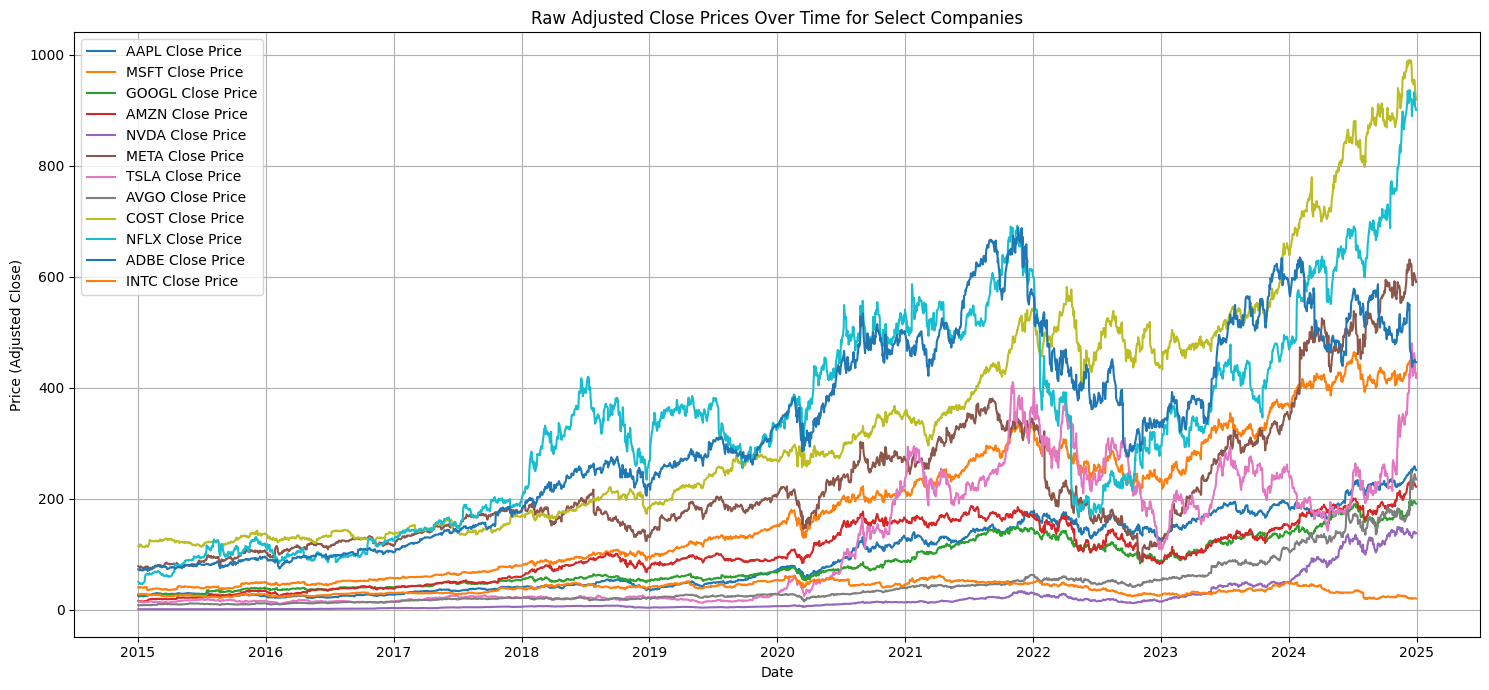

In [ ]:
Tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META',
           'TSLA', 'AVGO', 'COST', 'NFLX', 'ADBE', 'INTC']
Start_Date = '2015-01-01'
End_Date = '2024-12-31'

Drive_Path = '/content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/'

def download_stock_data(ticker, start, end):
    print(f"Downloading data for {ticker} from {start} to {end} ...")
    df = yf.download(ticker, start=start, end=end, auto_adjust=True)
    if df.empty:
        print(f"No data downloaded for {ticker}.")
    else:
        print(f"Data for {ticker} downloaded. Shape: {df.shape}")
    return df

all_raw_data = {}
for ticker in Tickers:
    data = download_stock_data(ticker, Start_Date, End_Date)
    if not data.empty:
        all_raw_data[ticker] = data

if not all_raw_data:
    print("No data available for any ticker after download.")
    exit()

# Save data to CSV files
print("\n--- Saving Raw Data to CSV Files ---")
for ticker, df in all_raw_data.items():
    if not df.empty:
        filename = os.path.join(Drive_Path, f"{ticker}.csv")
        df.to_csv(filename)
        print(f"Data for {ticker} saved to {filename}")

# Graphical Representation of Raw Data
print("\n Visualizing Raw Close Prices")
plt.figure(figsize=(15, 7))
for ticker, df in all_raw_data.items():
    if not df.empty:
        plt.plot(df.index, df['Close'], label=f'{ticker} Close Price')
plt.title('Raw Adjusted Close Prices Over Time for Select Companies')
plt.xlabel('Date')
plt.ylabel('Price (Adjusted Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Calculating Technical Indicators for Stock Data

In [ ]:
# Define common parameters for preprocessing
LOOK_BACK_VALUES = [30, 60, 90, 120]
TARGET_COLUMN = 'Close'
XGB_MAX_LAGS = 5
ARIMA_TEST_RATIO = 0.15

# Dictionaries to store processed data
all_processed_data = {}
prepared_data_for_all_models = {'lstm': {}, 'xgboost': {}, 'arima': {}}
sample_ticker_for_plot = None
TOP_FEATURES_FOR_MODELS = []
all_tickers_feature_importances = []

print("\n" + "="*50)
print("             CALCULATING TECHNICAL INDICATORS")
print("="*50)

def calculate_technical_indicators(df, ticker_name):
    """
    Calculates various technical indicators for the DataFrame.
    Returns: DataFrame with indicators, or empty DataFrame on error/missing data.
    """
    df_copy = df.copy()

    if df_copy.empty:
        print(f"Skipping {ticker_name}: DataFrame is empty.")
        return pd.DataFrame()

    # Ensure required columns are present and numeric
    required_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    if not all(col in df_copy.columns for col in required_cols):
        print(f"Skipping {ticker_name}: Missing one or more of OHLCV columns.")
        return pd.DataFrame()

    for col in required_cols:
        df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')

    print(f"Calculating technical indicators for {ticker_name}...")

    try:
        # Trend Indicators
        df_copy.ta.sma(length=200, append=True)
        df_copy.ta.sma(length=50, append=True)
        df_copy.ta.ema(length=26, append=True)
        df_copy.ta.macd(append=True)

        # Momentum Indicators
        df_copy.ta.rsi(length=14, append=True)
        df_copy.ta.willr(append=True)

        # Volatility Indicator
        df_copy.ta.bbands(append=True)

        # Volume Indicators
        df_copy.ta.obv(append=True)
        df_copy.ta.cmf(append=True)

        # Adding Daily Returns and Log Returns to measure change
        df_copy['Daily_Return'] = df_copy['Close'].pct_change()
        df_copy['Log_Return'] = np.log(df_copy['Close'] / df_copy['Close'].shift(1))

        # Replace inf/-inf with NaN (from log_return if Close price is 0 or very small)
        df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Drop rows with NaN values introduced by indicator calculations
        initial_rows = len(df_copy)
        df_copy.dropna(inplace=True)
        rows_dropped = initial_rows - len(df_copy)
        if rows_dropped > 0:
            print(f"   Dropped {rows_dropped} rows with NaN values after indicator calculation for {ticker_name}.")
        else:
            print(f"   No NaN rows dropped after indicator calculation for {ticker_name}.")

        print(f"Technical indicators calculated for {ticker_name}.")
        return df_copy

    except Exception as e:
        print(f"Error calculating indicators for {ticker_name}: {e}")
        return pd.DataFrame()

# Feature Engineering function to return ALL importances for a single ticker
def get_ticker_feature_importances(df_with_indicators):
    """
    Calculates feature importances using an XGBoost Regressor for a single ticker.
    Returns: A pandas Series of feature importances, or None if not enough data/features.
    """
    df_fe = df_with_indicators.copy()

    df_fe['Target_Close'] = df_fe[TARGET_COLUMN].shift(-1)
    df_fe.dropna(subset=['Target_Close'], inplace=True)

    excluded_cols_for_features = ['Target_Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'Log_Return']
    all_possible_features = [col for col in df_fe.columns
                             if col not in excluded_cols_for_features and pd.api.types.is_numeric_dtype(df_fe[col])]

    if not all_possible_features:
        return None

    X_fe = df_fe[all_possible_features]
    y_fe = df_fe['Target_Close']

    if len(X_fe) < 100: # Arbitrary minimum for sensible feature importance
        return None

    X_train_fe, _, y_train_fe, _ = train_test_split(
        X_fe, y_fe, test_size=0.2, shuffle=False # Maintain chronological order
    )

    # Scaling Features
    scaler = StandardScaler()
    X_train_fe_scaled = scaler.fit_transform(X_train_fe)
    X_train_fe = pd.DataFrame(X_train_fe_scaled, columns=X_train_fe.columns, index=X_train_fe.index)

    # Train an XGBoost Regressor to get feature importances
    xgb_model_fe = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42,
                                     n_jobs=-1, tree_method='hist', enable_categorical=False)
    xgb_model_fe.fit(X_train_fe, y_train_fe)

    return pd.Series(xgb_model_fe.feature_importances_, index=all_possible_features)


# Processing Loop for Indicators and Feature Selection
if os.path.exists(PROCESSED_DATA_PKL_PATH):
    print(f"Loading all_processed_data from {PROCESSED_DATA_PKL_PATH}...")
    with open(PROCESSED_DATA_PKL_PATH, 'rb') as f:
        all_processed_data = pickle.load(f)
    if all_processed_data:
        sample_ticker_for_plot = next(iter(all_processed_data))
    print("all_processed_data loaded. Skipping indicator calculation.")
else:
    print(f"Checking for CSV files in {Drive_Path}...")
    csv_files = [f for f in os.listdir(Drive_Path) if f.endswith('.csv')]

    if not csv_files:
        print(f"No CSV files found in {Drive_Path}. Please check 'Drive_Path'.")
    else:
        print(f"Processing {len(csv_files)} CSV files for indicator calculation and collecting feature importances...")
        for file_name in csv_files:
            ticker = file_name.replace('.csv', '')
            file_path = os.path.join(Drive_Path, file_name)

            try:
                df = pd.read_csv(file_path, skiprows=3)
                df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
                df['Date'] = pd.to_datetime(df['Date'])
                df.set_index('Date', inplace=True)
                df.sort_index(inplace=True)

                df_with_indicators = calculate_technical_indicators(df.copy(), ticker)

                if not df_with_indicators.empty:
                    all_processed_data[ticker] = df_with_indicators

                    if sample_ticker_for_plot is None:
                        sample_ticker_for_plot = ticker

                    print(f"   Calculating feature importances for {ticker}...")
                    importances = get_ticker_feature_importances(df_with_indicators)
                    if importances is not None:
                        all_tickers_feature_importances.append(importances)
                    else:
                        print(f"   Skipping feature importance calculation for {ticker} due to insufficient data or features.")

            except pd.errors.ParserError as e:
                print(f"Error parsing CSV file {file_name}: {e}.")
            except Exception as e:
                print(f"An unexpected error occurred while processing {file_name}: {e}")

    # Global Feature Selection after processing all tickers
    if all_tickers_feature_importances:
        print(f"\n Aggregating Feature Importances Across All {len(all_tickers_feature_importances)} Tickers.")
        combined_importances = pd.concat(all_tickers_feature_importances, axis=1).sum(axis=1)
        combined_importances = combined_importances.sort_values(ascending=False)

        num_features_to_select = 3
        TOP_FEATURES_FOR_MODELS = combined_importances.head(num_features_to_select).index.tolist()

        print(f"\nGlobal Top {num_features_to_select} Features (aggregated across all tickers):")
        print(combined_importances.head(num_features_to_select))
        print(f"\nSelected global top {num_features_to_select} features for models: {TOP_FEATURES_FOR_MODELS}")
    else:
        print("No feature importances were collected from any ticker. Cannot select global top features.")
        TOP_FEATURES_FOR_MODELS = []

    # Save all_processed_data after calculation
    if all_processed_data:
        with open(PROCESSED_DATA_PKL_PATH, 'wb') as f:
            pickle.dump(all_processed_data, f)
        print(f"All processed data with indicators saved to {PROCESSED_DATA_PKL_PATH}")
    else:
        print("No data was successfully processed to save to all_processed_data.pkl.")





             CALCULATING TECHNICAL INDICATORS
Checking for CSV files in /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/...
Processing 12 CSV files for indicator calculation and collecting feature importances...
Calculating technical indicators for AAPL...
   Dropped 199 rows with NaN values after indicator calculation for AAPL.
Technical indicators calculated for AAPL.
   Calculating feature importances for AAPL...
Calculating technical indicators for MSFT...
   Dropped 199 rows with NaN values after indicator calculation for MSFT.
Technical indicators calculated for MSFT.
   Calculating feature importances for MSFT...
Calculating technical indicators for GOOGL...
   Dropped 199 rows with NaN values after indicator calculation for GOOGL.
Technical indicators calculated for GOOGL.
   Calculating feature importances for GOOGL...
Calculating technical indicators for AMZN...
   Dropped 199 rows with NaN values after indicator calculation for AMZN.
Technical indicators calculated

## Visualization of Techniacl Indicators


--- Visualizing Technical Indicators for AAPL ---


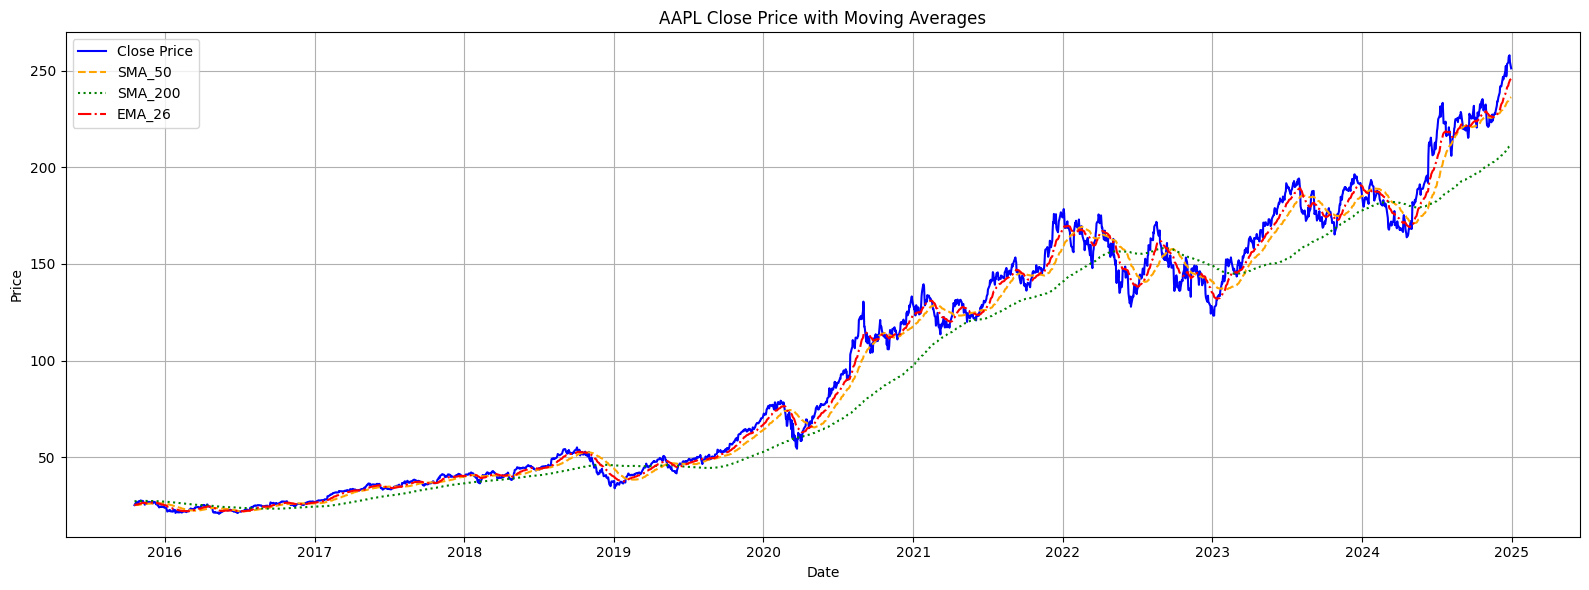

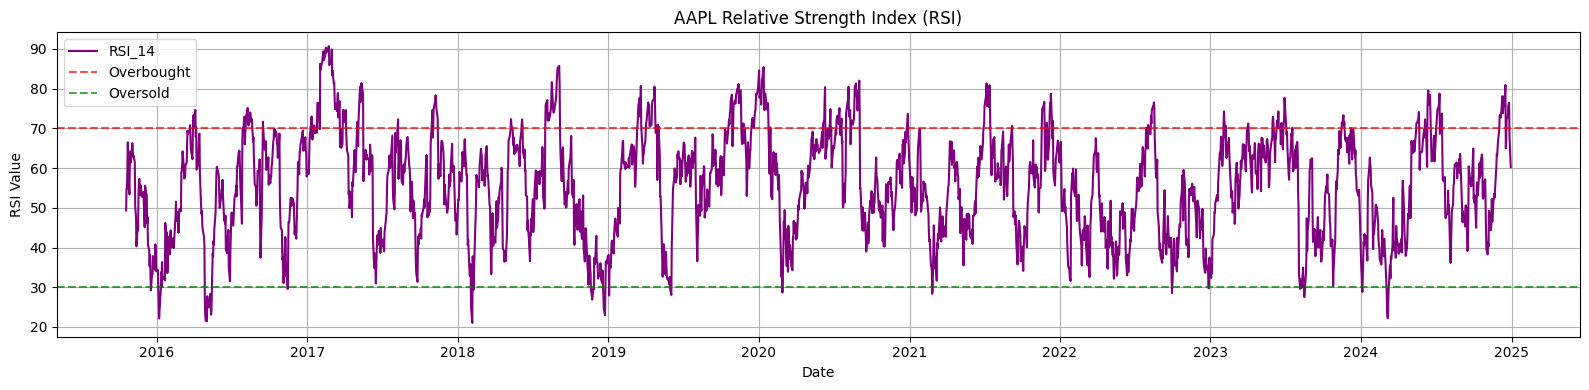

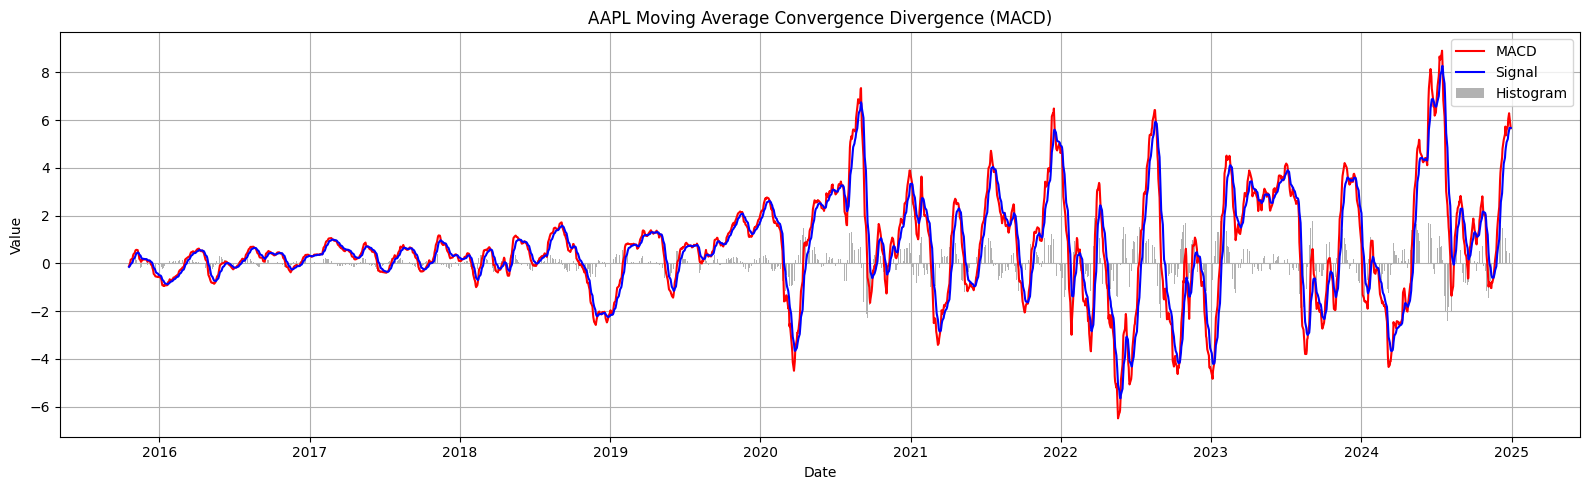

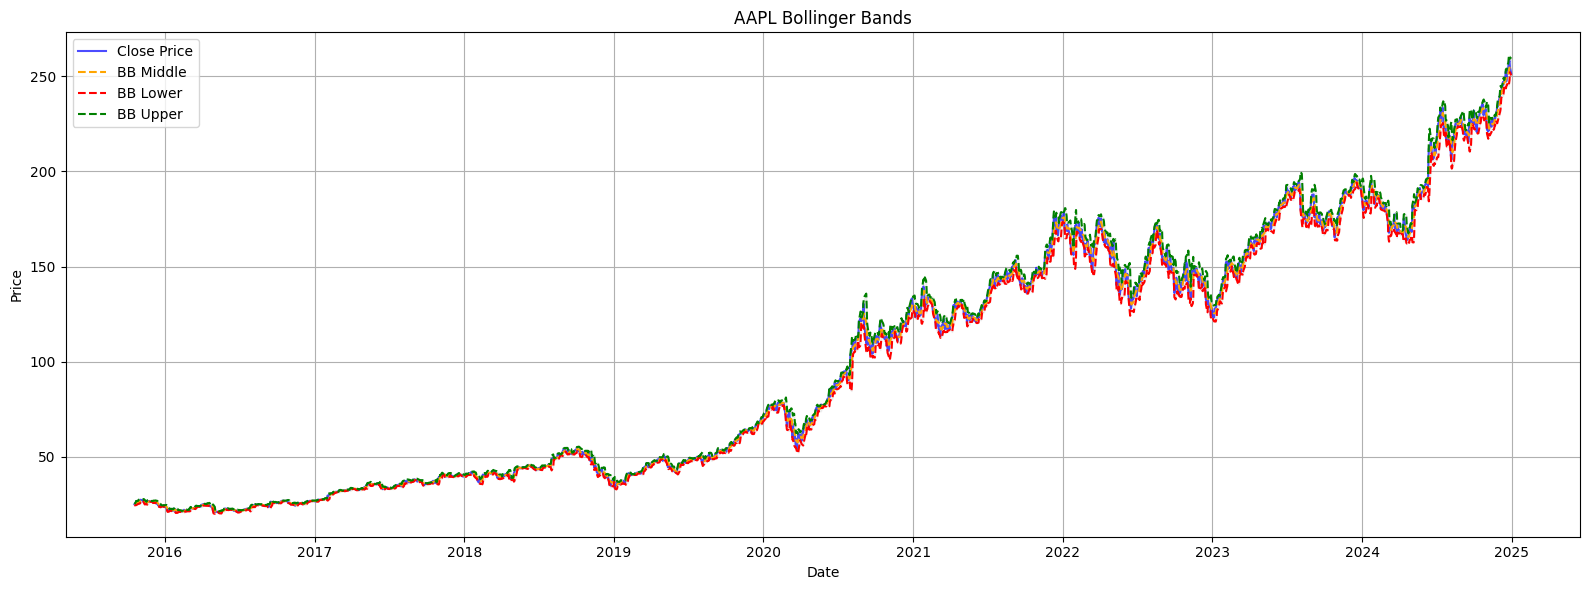

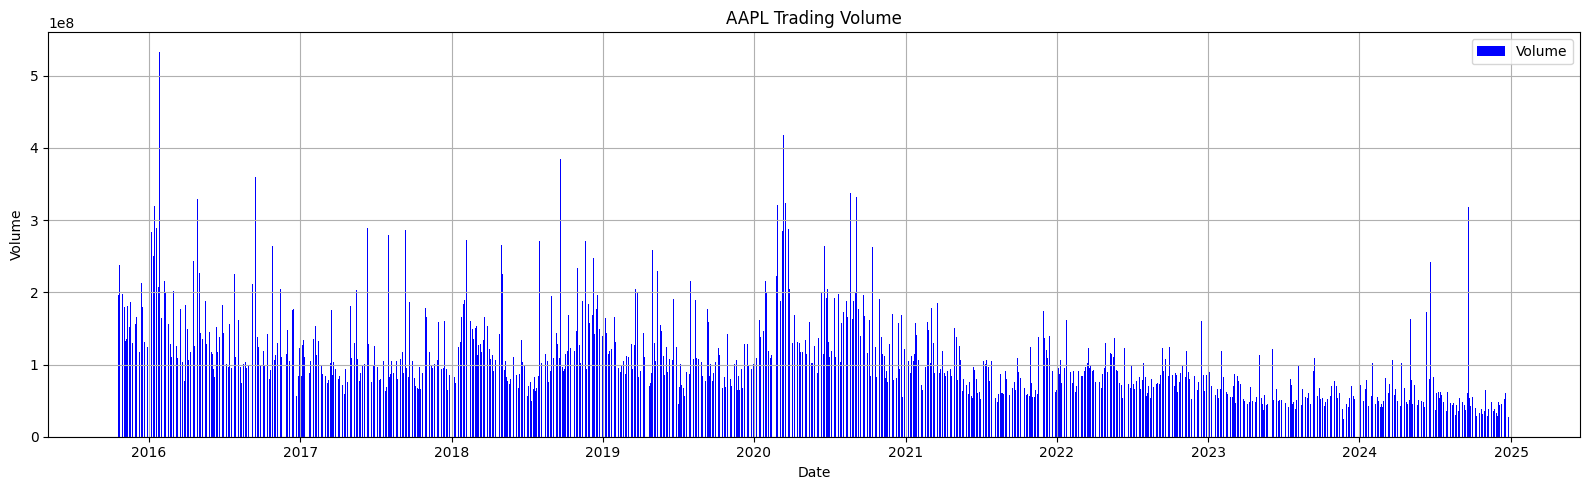

In [ ]:
# Graphical Representation of Indicators (for one ticker)
if sample_ticker_for_plot and sample_ticker_for_plot in all_processed_data:
    sample_df = all_processed_data[sample_ticker_for_plot]

    # Ensure enough data for indicators to stabilize and plot meaningfully
    if not sample_df.empty and len(sample_df) > 200:

        print(f"\n--- Visualizing Technical Indicators for {sample_ticker_for_plot} ---")
        # Plot 1: Close Price with Moving Averages
        plt.figure(figsize=(16, 6))
        plt.plot(sample_df['Close'], label='Close Price', color='blue')
        if 'SMA_50' in sample_df.columns:
            plt.plot(sample_df['SMA_50'], label='SMA_50', color='orange', linestyle='--')
        if 'SMA_200' in sample_df.columns:
            plt.plot(sample_df['SMA_200'], label='SMA_200', color='green', linestyle=':')
        if 'EMA_26' in sample_df.columns:
            plt.plot(sample_df['EMA_26'], label='EMA_26', color='red', linestyle='-.')
        plt.title(f'{sample_ticker_for_plot} Close Price with Moving Averages')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(Plots_Output_Path, f"{sample_ticker_for_plot}_Plot1_MA.png"))
        plt.close()

        # Plot 2: RSI
        if 'RSI_14' in sample_df.columns:
            plt.figure(figsize=(16, 4))
            plt.plot(sample_df['RSI_14'], label='RSI_14', color='purple')
            plt.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought')
            plt.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold')
            plt.title(f'{sample_ticker_for_plot} Relative Strength Index (RSI)')
            plt.xlabel('Date')
            plt.ylabel('RSI Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            plt.savefig(os.path.join(Plots_Output_Path, f"{sample_ticker_for_plot}_Plot2_RSI.png"))
            plt.close()

        # Plot 3: MACD
        if 'MACD_12_26_9' in sample_df.columns and 'MACDs_12_26_9' in sample_df.columns and 'MACDh_12_26_9' in sample_df.columns:
            plt.figure(figsize=(16, 5))
            plt.plot(sample_df['MACD_12_26_9'], label='MACD', color='red')
            plt.plot(sample_df['MACDs_12_26_9'], label='Signal', color='blue')
            plt.bar(sample_df.index, sample_df['MACDh_12_26_9'], label='Histogram', color='gray', alpha=0.6)
            plt.title(f'{sample_ticker_for_plot} Moving Average Convergence Divergence (MACD)')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            plt.savefig(os.path.join(Plots_Output_Path, f"{sample_ticker_for_plot}_Plot3_MACD.png"))
            plt.close()

        # Plot 4: Bollinger Bands
        if 'BBL_5_2.0' in sample_df.columns and 'BBM_5_2.0' in sample_df.columns and 'BBU_5_2.0' in sample_df.columns:
            plt.figure(figsize=(16, 6))
            plt.plot(sample_df['Close'], label='Close Price', color='blue', alpha=0.7)
            plt.plot(sample_df['BBM_5_2.0'], label='BB Middle', color='orange', linestyle='--')
            plt.plot(sample_df['BBL_5_2.0'], label='BB Lower', color='red', linestyle='--')
            plt.plot(sample_df['BBU_5_2.0'], label='BB Upper', color='green', linestyle='--')
            plt.fill_between(sample_df.index, sample_df['BBL_5_2.0'], sample_df['BBU_5_2.0'], color='gray', alpha=0.1)
            plt.title(f'{sample_ticker_for_plot} Bollinger Bands')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            plt.savefig(os.path.join(Plots_Output_Path, f"{sample_ticker_for_plot}_Plot4_BBands.png"))
            plt.close()

        # Plot 5: Volume
        plt.figure(figsize=(16, 5))
        plt.bar(sample_df.index, sample_df['Volume'], color='blue', label='Volume')
        plt.title(f'{sample_ticker_for_plot} Trading Volume')
        plt.xlabel('Date')
        plt.ylabel('Volume')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(Plots_Output_Path, f"{sample_ticker_for_plot}_Plot5_Volume.png"))
        plt.close()

    else:
        print(f"Not enough data (need >200 data points) for {sample_ticker_for_plot} or indicators not present to plot.")
else:
    print("No sample ticker available for plotting.")

## Data Preprocessing

In [ ]:
print("\n\n" + "="*50)
print("             MODEL-SPECIFIC DATA PREPROCESSING")
print("="*50)

def preprocess_for_lstm_optimized(df, look_back, selected_features, ticker_name):
    """
    Prepares data for LSTM: creates target, directly creates 3D sequences
    from relevant columns (selected_features), scales data, and splits into train, validation, test sets chronologically.
    Returns: A dictionary containing all prepared datasets and scalers.
    """
    print(f"Starting optimized data preprocessing for LSTM for {ticker_name} with look_back={look_back}...")

    df_copy = df.copy()

    df_copy['Target_Close'] = df_copy[TARGET_COLUMN].shift(-1)
    df_copy.dropna(subset=['Target_Close'], inplace=True)

    # Check for minimum data before proceeding
    min_rows_needed = look_back + 10 # Heuristic minimum
    if len(df_copy) < min_rows_needed:
        print(f"  Skipping {ticker_name} (LB={look_back}) - Insufficient rows ({len(df_copy)}).")
        return {'X_train_lstm': np.array([])}

    features_to_use = [f for f in selected_features if f in df_copy.columns]
    if not features_to_use:
        print(f"No selected features found in DataFrame for {ticker_name}. Using all available numeric features.")
        features_to_use = [col for col in df_copy.columns
                             if col not in ['Target_Close'] and pd.api.types.is_numeric_dtype(df_copy[col])]
        if not features_to_use:
            print(f"No numeric features available for LSTM for {ticker_name}.")
            return {'X_train_lstm': np.array([])}

    df_copy.dropna(subset=features_to_use, inplace=True)
    if len(df_copy) < min_rows_needed:
        print(f"  Warning: Skipping {ticker_name} (LB={look_back}) after NaN drop - Insufficient rows ({len(df_copy)}).")
        return {'X_train_lstm': np.array([])}

    X_full = df_copy[features_to_use]
    y_full = df_copy['Target_Close']

    print(f"Features used by LSTM: {features_to_use}")
    print(f"Rows available for LSTM after initial target shift and feature NaNs: {len(X_full)}")

    train_size = int(len(X_full) * 0.7)
    val_size = int(len(X_full) * 0.15)

    # Final check on split sizes
    if train_size < look_back + 1 or val_size < look_back + 1 or (len(X_full) - train_size - val_size) < look_back + 1:
        print(f"  Skipping {ticker_name} (LB={look_back}) - Splits are too small for sequence creation.")
        return {'X_train_lstm': np.array([])}


    X_train_raw = X_full.iloc[:train_size]
    y_train_raw = y_full.iloc[:train_size]
    X_val_raw = X_full.iloc[train_size : train_size + val_size]
    y_val_raw = y_full.iloc[train_size : train_size + val_size]
    X_test_raw = X_full.iloc[train_size + val_size :]
    y_test_raw = y_full.iloc[train_size + val_size :]

    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X_train_scaled = scaler_X.fit_transform(X_train_raw)
    y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))
    X_val_scaled = scaler_X.transform(X_val_raw)
    y_val_scaled = scaler_y.transform(y_val_raw.values.reshape(-1, 1))
    X_test_scaled = scaler_X.transform(X_test_raw)
    y_test_scaled = scaler_y.transform(y_test_raw.values.reshape(-1, 1))

    def create_lstm_sequences_optimized(features_scaled, target_scaled, look_back_window):
        Xs, ys = [], []
        if len(features_scaled) <= look_back_window:
            return np.array([]), np.array([])
        for i in range(len(features_scaled) - look_back_window):
            Xs.append(features_scaled[i:(i + look_back_window)])
            ys.append(target_scaled[i + look_back_window])
        return np.array(Xs), np.array(ys)

    X_train_lstm, y_train_lstm = create_lstm_sequences_optimized(X_train_scaled, y_train_scaled, look_back)
    X_val_lstm, y_val_lstm = create_lstm_sequences_optimized(X_val_scaled, y_val_scaled, look_back)
    X_test_lstm, y_test_lstm = create_lstm_sequences_optimized(X_test_scaled, y_test_scaled, look_back)

    y_test_raw_lstm_aligned = y_test_raw.iloc[look_back:]

    print(f"Data preprocessing for LSTM (look_back={look_back}) complete.")
    print(f"X_train_lstm shape: {X_train_lstm.shape}, y_train_lstm shape: {y_train_lstm.shape}")

    return {
        'X_train_raw': X_train_raw, 'y_train_raw': y_train_raw,
        'X_val_raw': X_val_raw, 'y_val_raw': y_val_raw,
        'X_test_raw': X_test_raw, 'y_test_raw': y_test_raw_lstm_aligned,
        'X_train_scaled': X_train_scaled, 'y_train_scaled': y_train_scaled,
        'X_val_scaled': X_val_scaled, 'y_val_scaled': y_val_scaled,
        'X_test_scaled': X_test_scaled, 'y_test_scaled': y_test_scaled,
        'X_train_lstm': X_train_lstm, 'y_train_lstm': y_train_lstm,
        'X_val_lstm': X_val_lstm, 'y_val_lstm': y_val_lstm,
        'X_test_lstm': X_test_lstm, 'y_test_lstm': y_test_lstm,
        'scaler_X': scaler_X, 'scaler_y': scaler_y,
        'original_df_after_preprocessing': df_copy
    }

def preprocess_for_xgboost_optimized(df, max_lags=5, selected_features=None, ticker_name=None):
    """
    Prepares data for XGBoost: creates target, adds multiple lags for relevant features,
    and splits into train, validation, test sets chronologically.
    """
    print(f"Starting data preprocessing for XGBoost for {ticker_name}...")

    df_copy = df.copy()

    # Target variable: Next day's Close price
    df_copy['Target_Close'] = df_copy[TARGET_COLUMN].shift(-1)

    if selected_features:
        features_for_lagging_xgb = [f for f in selected_features if f in df_copy.columns]
        if not features_for_lagging_xgb:
             print(f"No selected features found in DataFrame for {ticker_name}. Using all available numeric features.")
             features_for_lagging_xgb = [col for col in df_copy.columns
                                         if col not in ['Target_Close'] and pd.api.types.is_numeric_dtype(df_copy[col])]
    else: # If no specific features are selected, use all available numeric features
        features_for_lagging_xgb = [col for col in df_copy.columns
                                     if col not in ['Target_Close'] and pd.api.types.is_numeric_dtype(df_copy[col])]

    print(f"Features used by XGBoost (before lagging): {features_for_lagging_xgb}")

    # Drop NaNs introduced by `Target_Close` before creating lags
    df_copy.dropna(subset=['Target_Close'], inplace=True)
    df_copy.dropna(subset=features_for_lagging_xgb, inplace=True)

    # Lags represent trading days: 1 day, 1 week, 1 month, 3 months, 6 months, 1 year
    lags_to_use = [1, 5, 21, 63, 126, 252]
    print(f"Creating strategic lags for {len(features_for_lagging_xgb)} features for XGBoost: {lags_to_use}...")

    for feature in features_for_lagging_xgb:
        for i in lags_to_use:
            df_copy[f'{feature}_Lag_{i}'] = df_copy[feature].shift(i)

    # Drop rows with NaN values created by lagging and target
    initial_rows = len(df_copy)
    df_copy.dropna(inplace=True)
    rows_dropped = initial_rows - len(df_copy)
    if rows_dropped > 0:
        print(f"  Dropped {rows_dropped} rows due to NaNs after creating XGBoost lags and Target_Close.")
    else:
        print(f"  No NaN rows dropped for {ticker_name} after XGBoost lags and Target_Close.")

    # Separate features (X) and target (y)
    cols_to_drop_from_X_xgb = ['Target_Close'] + features_for_lagging_xgb
    X = df_copy.drop(columns=[col for col in cols_to_drop_from_X_xgb if col in df_copy.columns], errors='ignore')
    y = df_copy['Target_Close']

    print("Data preprocessing for XGBoost complete.")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    # Chronological Split for Train, Validation, Test
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_val, y_val = X.iloc[train_size : train_size + val_size], y.iloc[train_size : train_size + val_size]
    X_test, y_test = X.iloc[train_size + val_size :], y.iloc[train_size + val_size :]

    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'original_df_after_preprocessing': df_copy
    }

def preprocess_for_arima(df, test_split_ratio, selected_features, ticker_name):
    """
    Prepares data for ARIMA/ARIMAX: splits the target series and
    exogenous features chronologically.
    Returns: A dictionary containing the train/test series and features.
    """
    print(f"Starting data preprocessing for ARIMA for {ticker_name}...")

    df_copy = df.copy()
    df_copy = df_copy.sort_index()

    # Check for minimum data before proceeding
    min_rows_needed = 50 # Heuristic minimum for ARIMA
    if len(df_copy) < min_rows_needed:
        print(f"  Skipping {ticker_name} - Insufficient rows ({len(df_copy)}).")
        return {'train_data': pd.Series()}

    # The target series for ARIMA is still the 'Close' price
    series = df_copy[TARGET_COLUMN].copy()
    series.dropna(inplace=True)
    if len(series) < min_rows_needed:
        print(f"  Skipping {ticker_name} after NaN drop - Insufficient rows ({len(series)}).")
        return {'train_data': pd.Series()}

    # Select exogenous features
    if selected_features:
        exog_features = df_copy[selected_features].copy()
    else:
        excluded_cols = [TARGET_COLUMN, 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'Log_Return']
        all_numeric_features = [col for col in df_copy.columns
                                if col not in excluded_cols and pd.api.types.is_numeric_dtype(df_copy[col])]
        exog_features = df_copy[all_numeric_features].copy()
    exog_features.dropna(inplace=True)

    common_index = series.index.intersection(exog_features.index)
    series = series.loc[common_index]
    exog_features = exog_features.loc[common_index]

    if len(series) < min_rows_needed:
        print(f"  Skipping {ticker_name} after feature alignment - Insufficient rows ({len(series)}).")
        return {'train_data': pd.Series()}


    # Check for Stationarity and Note Differencing
    print("Checking for stationarity (ADF test) for ARIMA...")
    adf_result = adfuller(series)
    adf_p_value = adf_result[1]
    print(f"ADF p-value: {adf_p_value:.4f}")

    if adf_p_value > 0.05:
        print("Series is likely non-stationary. ARIMA model will likely use differencing (d > 0).")
    else:
        print("Series appears stationary (d=0).")

    train_size = int(len(series) * (1 - test_split_ratio))
    train_data = series.iloc[:train_size]
    test_data = series.iloc[train_size:]

    train_exog = exog_features.iloc[:train_size]
    test_exog = exog_features.iloc[train_size:]

    print("Data preprocessing for ARIMA complete.")
    print(f"Train data size: {len(train_data)}, Test data size: {len(test_data)}")
    print(f"Exogenous features shape: {train_exog.shape}")

    return {
        'train_data': train_data, 'test_data': test_data,
        'train_exog': train_exog, 'test_exog': test_exog,
        'adf_p_value': adf_p_value, 'original_full_series': df_copy[TARGET_COLUMN]
    }

# Main Loop for Data Preprocessing
if os.path.exists(PREPARED_DATA_PKL_PATH):
    print(f"Loading prepared_data_for_all_models from {PREPARED_DATA_PKL_PATH}...")
    with open(PREPARED_DATA_PKL_PATH, 'rb') as f:
        prepared_data_for_all_models = pickle.load(f)
    print("prepared_data_for_all_models loaded. Skipping preprocessing.")
else:
    if not all_processed_data:
        print("No data available in 'all_processed_data' from preprocessing.")
    else:
        print(f"Processing data for {len(all_processed_data)} tickers from 'all_processed_data'.")

        for ticker, df_with_indicators in all_processed_data.items():
            print(f"\n Preprocessing data for {ticker} for various models")
            if df_with_indicators.empty:
                print(f"Skipping preprocessing for {ticker} due to empty DataFrame).")
                continue

            df_for_model_prep = df_with_indicators.copy()

            # Loop through LOOK_BACK values to preprocess for LSTM
            prepared_data_for_all_models['lstm'][ticker] = {}
            for current_look_back in LOOK_BACK_VALUES:
                estimated_min_samples = int(len(df_for_model_prep) * 0.15)
                if estimated_min_samples > current_look_back + 1:
                    lstm_data = preprocess_for_lstm_optimized(df_for_model_prep, current_look_back, TOP_FEATURES_FOR_MODELS, ticker)
                    if 'X_train_lstm' in lstm_data and lstm_data['X_train_lstm'].shape[0] > 0 and lstm_data['X_val_lstm'].shape[0] > 0 and lstm_data['X_test_lstm'].shape[0] > 0:
                        prepared_data_for_all_models['lstm'][ticker][current_look_back] = lstm_data
                    else:
                        print(f"Not enough LSTM sequences generated for {ticker} with look_back={current_look_back}. Skipping LSTM data for this look_back.")
                else:
                    print(f"{ticker} has only {len(df_for_model_prep)} rows, insufficient for LSTM with look_back={current_look_back}.")


            # Preprocess for XGBoost
            min_rows_needed_for_xgb = 252 + 2 # Longest lag plus one for target and one for safety
            if len(df_for_model_prep) >= min_rows_needed_for_xgb:
                xgb_data = preprocess_for_xgboost_optimized(df_for_model_prep, max_lags=XGB_MAX_LAGS, selected_features=TOP_FEATURES_FOR_MODELS, ticker_name=ticker)
                if 'X_train' in xgb_data and not xgb_data['X_train'].empty:
                    prepared_data_for_all_models['xgboost'][ticker] = xgb_data
            else:
                print(f"Warning: {ticker} has only {len(df_for_model_prep)} rows, insufficient for XGBoost preprocessing.")

            # Preprocess for ARIMAX
            if len(df_for_model_prep) >= 50:
                arima_data = preprocess_for_arima(df_for_model_prep, test_split_ratio=ARIMA_TEST_RATIO, selected_features=TOP_FEATURES_FOR_MODELS, ticker_name=ticker)
                if 'train_data' in arima_data and not arima_data['train_data'].empty:
                    prepared_data_for_all_models['arima'][ticker] = arima_data
            else:
                print(f"Warning: {ticker} has only {len(df_for_model_prep)} rows, which is too few for ARIMA modeling.")

    # Save prepared_data_for_all_models after preprocessing
    if any(v for d in prepared_data_for_all_models['lstm'].values() for v in d.values()) or \
       any(prepared_data_for_all_models['xgboost'].values()) or \
       any(prepared_data_for_all_models['arima'].values()):
        with open(PREPARED_DATA_PKL_PATH, 'wb') as f:
            pickle.dump(prepared_data_for_all_models, f)
        print(f"All prepared data for models saved to {PREPARED_DATA_PKL_PATH}")
    else:
        print("No data was successfully prepared to save to prepared_data_for_all_models.pkl.")

# Check if any data was successfully prepared
if not any(v for d in prepared_data_for_all_models['lstm'].values() for v in d.values()) and \
   not prepared_data_for_all_models['xgboost'] and \
   not prepared_data_for_all_models['arima']:
    print("No data was successfully prepared for any model.")
else:
    print("\n" + "="*80)
    print("              DATA PREPROCESSING COMPLETE.")
    print("="*80)



             MODEL-SPECIFIC DATA PREPROCESSING
Processing data for 12 tickers from 'all_processed_data'.

--- Preprocessing data for AAPL for various models ---
Starting optimized data preprocessing for LSTM for AAPL with look_back=30...
Features used by LSTM: ['BBM_5_2.0', 'BBL_5_2.0', 'SMA_200']
Rows available for LSTM after initial target shift and feature NaNs: 2314
Data preprocessing for LSTM (look_back=30) complete.
X_train_lstm shape: (1589, 30, 3), y_train_lstm shape: (1589, 1)
Starting optimized data preprocessing for LSTM for AAPL with look_back=60...
Features used by LSTM: ['BBM_5_2.0', 'BBL_5_2.0', 'SMA_200']
Rows available for LSTM after initial target shift and feature NaNs: 2314
Data preprocessing for LSTM (look_back=60) complete.
X_train_lstm shape: (1559, 60, 3), y_train_lstm shape: (1559, 1)
Starting optimized data preprocessing for LSTM for AAPL with look_back=90...
Features used by LSTM: ['BBM_5_2.0', 'BBL_5_2.0', 'SMA_200']
Rows available for LSTM after initial t

### Graphical Representation of Pre-Processed Data


--- Visualizing Preprocessed Data ---

--- Visualizing LSTM Test Data for AAPL (LookBack=30) ---


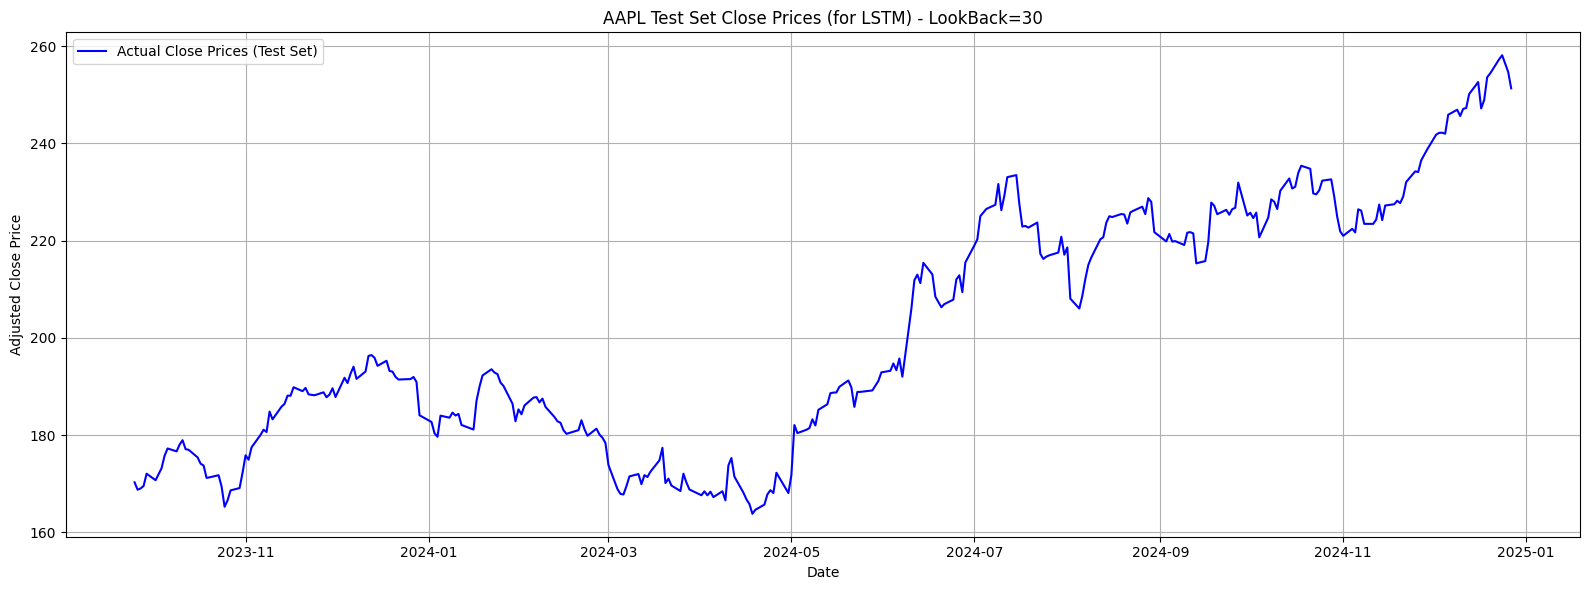


--- Example LSTM Input Sequence Shape for AAPL (LookBack=30) ---
Shape of one LSTM input sequence (timesteps, features): (30, 3)
Number of features used per timestep: 3

--- Visualizing XGBoost Test Data for AAPL ---


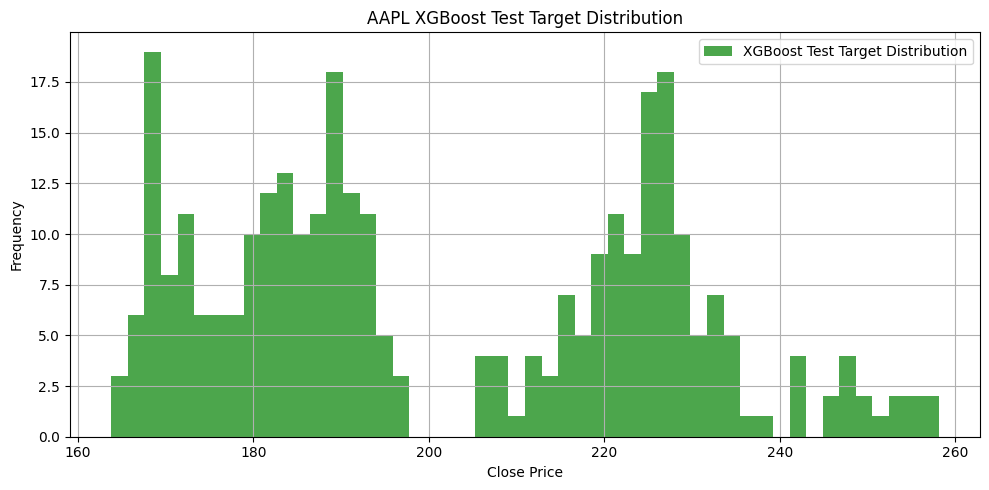


--- Example XGBoost Input Features Shape for AAPL ---
Shape of one XGBoost input sample (features): (37,)
Total number of features (including lags): 37

--- Visualizing ARIMA Train/Test Split for AAPL ---


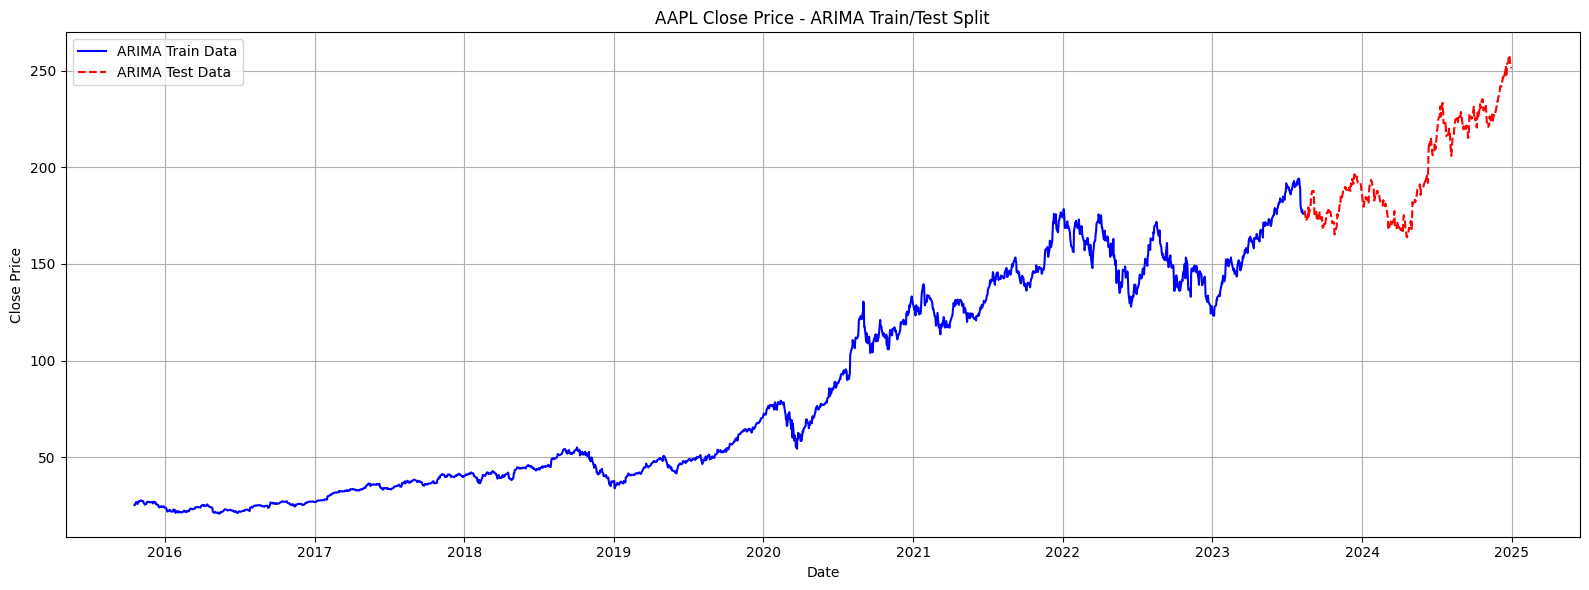


ADF p-value for AAPL ARIMA series: 0.9889


In [ ]:
print("\n Visualizing Preprocessed Data")
sample_ticker_for_lstm_plot = None
# Find a ticker that has at least one look_back data prepared for LSTM
for ticker_name, look_back_data in prepared_data_for_all_models['lstm'].items():
    if look_back_data: # Check if the inner dictionary is not empty
        first_look_back_key = next(iter(look_back_data)) # Get the first look_back key
        data = look_back_data[first_look_back_key]
        if data['X_test_lstm'].shape[0] > 0 and data['y_test_raw'].shape[0] > 0:
            sample_ticker_for_lstm_plot = ticker_name
            sample_look_back_for_plot = first_look_back_key
            break

if sample_ticker_for_lstm_plot:
    print(f"\n Visualizing LSTM Test Data for {sample_ticker_for_lstm_plot} (LookBack={sample_look_back_for_plot})")
    lstm_data_for_plot = prepared_data_for_all_models['lstm'][sample_ticker_for_lstm_plot][sample_look_back_for_plot]

    plt.figure(figsize=(16, 6))
    plt.plot(lstm_data_for_plot['y_test_raw'].index, lstm_data_for_plot['y_test_raw'], label='Actual Close Prices (Test Set)', color='blue')
    plt.title(f'{sample_ticker_for_lstm_plot} Test Set Close Prices (for LSTM) - LookBack={sample_look_back_for_plot}')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, f"{sample_ticker_for_lstm_plot}_LSTM_Test_Data_lb{sample_look_back_for_plot}.png"))
    plt.close()

    print(f"\n Example LSTM Input Sequence Shape for {sample_ticker_for_lstm_plot} (LookBack={sample_look_back_for_plot})")
    if lstm_data_for_plot['X_train_lstm'].shape[0] > 0:
        first_lstm_input_sample = lstm_data_for_plot['X_train_lstm'][0]
        print(f"Shape of one LSTM input sequence (timesteps, features): {first_lstm_input_sample.shape}")
        print(f"Number of features used per timestep: {first_lstm_input_sample.shape[1]}")

sample_ticker_for_xgb_plot = None
for ticker_name, data in prepared_data_for_all_models['xgboost'].items():
    if data['X_test'].shape[0] > 0 and data['y_test'].shape[0] > 0:
        sample_ticker_for_xgb_plot = ticker_name
        break
if sample_ticker_for_xgb_plot:
    print(f"\n Visualizing XGBoost Test Data for {sample_ticker_for_xgb_plot}")
    xgb_data_for_plot = prepared_data_for_all_models['xgboost'][sample_ticker_for_xgb_plot]

    plt.figure(figsize=(10, 5))
    plt.hist(xgb_data_for_plot['y_test'], bins=50, alpha=0.7, color='green', label='XGBoost Test Target Distribution')
    plt.title(f'{sample_ticker_for_xgb_plot} XGBoost Test Target Distribution')
    plt.xlabel('Close Price')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, f"{sample_ticker_for_xgb_plot}_XGBoost_Test_Target_Distribution.png"))
    plt.close()

    print(f"\n Example XGBoost Input Features Shape for {sample_ticker_for_xgb_plot}")
    if xgb_data_for_plot['X_train'].shape[0] > 0:
        print(f"Shape of one XGBoost input sample (features): {xgb_data_for_plot['X_train'].iloc[0].shape}")
        print(f"Total number of features (including lags): {xgb_data_for_plot['X_train'].shape[1]}")

sample_ticker_for_arima_plot = None
for ticker_name, data in prepared_data_for_all_models['arima'].items():
    if data['test_data'].shape[0] > 0:
        sample_ticker_for_arima_plot = ticker_name
        break
if sample_ticker_for_arima_plot:
    print(f"\n Visualizing ARIMAX Train/Test Split for {sample_ticker_for_arima_plot}")
    arima_data_for_plot = prepared_data_for_all_models['arima'][sample_ticker_for_arima_plot]

    plt.figure(figsize=(16, 6))
    plt.plot(arima_data_for_plot['train_data'].index, arima_data_for_plot['train_data'], label='ARIMA Train Data', color='blue')
    plt.plot(arima_data_for_plot['test_data'].index, arima_data_for_plot['test_data'], label='ARIMA Test Data', color='red', linestyle='--')
    plt.title(f'{sample_ticker_for_arima_plot} Close Price - ARIMAX Train/Test Split')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, f"{sample_ticker_for_arima_plot}_ARIMA_Train_Test_Split.png"))
    plt.close()

    print(f"\nADF p-value for {sample_ticker_for_arima_plot} ARIMA series: {arima_data_for_plot['adf_p_value']:.4f}")



## LSTM Model

In [ ]:
def build_hypermodel(hp, input_shape):
    model = Sequential()

    # Determine whether a second LSTM layer will be added
    add_second_lstm_layer = hp.Boolean('add_second_lstm_layer', default=False)

    return_sequences_for_first_lstm = add_second_lstm_layer

    # Tune the number of LSTM units in the first layer
    lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=96, step=32)
    model.add(LSTM(units=lstm_units_1, return_sequences=return_sequences_for_first_lstm, input_shape=input_shape))

    # Tune dropout rate for the first dropout layer
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.2, step=0.1)
    model.add(Dropout(dropout_rate_1))

    # Add second LSTM layer conditionally
    if add_second_lstm_layer:
        lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=64, step=32)
        model.add(LSTM(units=lstm_units_2, return_sequences=False))
        dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.1, max_value=0.2, step=0.1)
        model.add(Dropout(dropout_rate_2))

    model.add(Dense(units=1))

    # Tune learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

overall_best_rmse_val = float('inf')
overall_best_ticker_val = None
overall_best_params_val = None
overall_best_history_val = None
overall_best_look_back_val = None
overall_best_lstm_mape = float('inf')

if not prepared_data_for_all_models['lstm']:
    print("No LSTM data prepared for any ticker. Skipping LSTM model training.")
else:
    for ticker, look_back_datasets in prepared_data_for_all_models['lstm'].items():
        if not look_back_datasets:
            print(f"No LSTM data prepared for {ticker} for any look_back value. Skipping.")
            continue

        for current_look_back, data in look_back_datasets.items():
            X_train_lstm = data['X_train_lstm']
            y_train_lstm = data['y_train_lstm']
            X_val_lstm = data['X_val_lstm']
            y_val_lstm = data['y_val_lstm']
            X_test_lstm = data['X_test_lstm']
            y_test_lstm = data['y_test_lstm']
            scaler_y = data['scaler_y']

            if X_train_lstm.shape[0] == 0 or X_val_lstm.shape[0] == 0 or X_test_lstm.shape[0] == 0:
                print(f"Skipping LSTM tuning for {ticker} with look_back={current_look_back}: Insufficient data.")
                continue

            model_file_name = f'{ticker}_lb{current_look_back}_best_lstm_model.h5'
            model_path = os.path.join(TRAINED_LSTM_MODELS_DIR, model_file_name)

            if os.path.exists(model_path) and 'best_y_pred_lstm_original_scale' in data:
                print(f"Loading trained LSTM model for {ticker} (LB={current_look_back}) from {model_path} and its predictions...")
                lstm_model = tf.keras.models.load_model(model_path)
                y_pred = data['best_y_pred_lstm_original_scale']
                rmse = data['best_rmse']
                mae = data['best_mae']
                mape = data.get('best_mape', np.nan) # Retrieve MAPE
                history_data = data['best_lstm_training_history']
                print(f"  Loaded - Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
            else:
                print(f"\n--- Starting KerasTuner Random Search for {ticker} (LookBack={current_look_back}) ---")
                input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

                tuner = kt.RandomSearch(
                    lambda hp: build_hypermodel(hp, input_shape),
                    objective='val_loss',
                    max_trials=10,
                    executions_per_trial=1,
                    directory='keras_tuner_logs',
                    project_name=f'lstm_tuning_{ticker}_lb{current_look_back}',
                    overwrite=False
                )

                early_stopping_tuner = KerasEarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

                tuner.search(X_train_lstm, y_train_lstm,
                              epochs=75,
                              batch_size=32,
                              validation_data=(X_val_lstm, y_val_lstm),
                              callbacks=[early_stopping_tuner],
                              verbose=0)

                best_hp_for_ticker_lb = tuner.get_best_hyperparameters(num_trials=1)
                if not best_hp_for_ticker_lb:
                    print(f"  No best hyperparameters found for {ticker} with look_back={current_look_back}. Skipping.")
                    continue
                best_hp_for_ticker_lb = best_hp_for_ticker_lb[0]
                best_model_for_ticker_lb = tuner.get_best_models(num_models=1)[0]

                print(f"\nBest hyperparameters for {ticker} (LookBack={current_look_back}):")
                print(best_hp_for_ticker_lb.values)

                test_loss = best_model_for_ticker_lb.evaluate(X_test_lstm, y_test_lstm, verbose=0)
                y_pred_scaled = best_model_for_ticker_lb.predict(X_test_lstm, verbose=0)
                y_pred = scaler_y.inverse_transform(y_pred_scaled)
                y_actual_raw = data['y_test_raw']

                rmse = math.sqrt(mean_squared_error(y_actual_raw, y_pred))
                mae = mean_absolute_error(y_actual_raw, y_pred)
                mape = mean_absolute_percentage_error(y_actual_raw, y_pred)

                print(f"  {ticker} (LB={current_look_back}) - Best Test Loss (MSE): {test_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

                best_model_for_ticker_lb.save(model_path)
                print(f"Best LSTM model for {ticker} (LB={current_look_back}) saved to {model_path}")

                re_built_best_model = tuner.hypermodel.build(best_hp_for_ticker_lb)
                history_best_model = re_built_best_model.fit(X_train_lstm, y_train_lstm,
                                                            epochs=75,
                                                            batch_size=32,
                                                            validation_data=(X_val_lstm, y_val_lstm),
                                                            callbacks=[early_stopping_tuner],
                                                            verbose=0)
                history_data = history_best_model.history

            data['best_y_pred_lstm_original_scale'] = y_pred
            data['best_y_actual_lstm_original_scale_for_plot'] = y_actual_raw
            data['best_lstm_hyperparams'] = best_hp_for_ticker_lb.values if 'best_hp_for_ticker_lb' in locals() else data.get('best_lstm_hyperparams')
            data['best_lstm_training_history'] = history_data
            data['best_rmse'] = rmse
            data['best_mae'] = mae
            data['best_mape'] = mape

            if rmse < overall_best_rmse_val:
                overall_best_rmse_val = rmse
                overall_best_ticker_val = ticker
                overall_best_params_val = data['best_lstm_hyperparams']
                overall_best_look_back_val = current_look_back
                overall_best_history_val = history_data

            if mape < overall_best_lstm_mape:
                overall_best_lstm_mape = mape # Track overall best MAPE


--- Starting KerasTuner Random Search for AAPL (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AAPL_lb30/tuner0.json

Best hyperparameters for AAPL (LookBack=30):
{'add_second_lstm_layer': True, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  AAPL (LB=30) - Best Test Loss (MSE): 0.0091, RMSE: 15.0847, MAE: 11.8948, MAPE: 12.36%
Best LSTM model for AAPL (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AAPL_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for AAPL (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AAPL_lb60/tuner0.json

Best hyperparameters for AAPL (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.2, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  AAPL (LB=60) - Best Test Loss (MSE): 0.0022, RMSE: 7.4591, MAE: 5.8597, MAPE: 12.78%
Best LSTM model for AAPL (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AAPL_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for AAPL (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AAPL_lb90/tuner0.json

Best hyperparameters for AAPL (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  AAPL (LB=90) - Best Test Loss (MSE): 0.0021, RMSE: 7.2665, MAE: 5.7748, MAPE: 13.20%
Best LSTM model for AAPL (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AAPL_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for AAPL (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AAPL_lb120/tuner0.json

Best hyperparameters for AAPL (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  AAPL (LB=120) - Best Test Loss (MSE): 0.0028, RMSE: 8.2868, MAE: 6.5829, MAPE: 13.49%
Best LSTM model for AAPL (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AAPL_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for MSFT (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_MSFT_lb30/tuner0.json

Best hyperparameters for MSFT (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  MSFT (LB=30) - Best Test Loss (MSE): 0.0020, RMSE: 13.0227, MAE: 10.9368, MAPE: 9.28%
Best LSTM model for MSFT (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/MSFT_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for MSFT (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_MSFT_lb60/tuner0.json

Best hyperparameters for MSFT (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  MSFT (LB=60) - Best Test Loss (MSE): 0.0018, RMSE: 12.2486, MAE: 10.2539, MAPE: 6.45%
Best LSTM model for MSFT (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/MSFT_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for MSFT (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_MSFT_lb90/tuner0.json

Best hyperparameters for MSFT (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  MSFT (LB=90) - Best Test Loss (MSE): 0.0011, RMSE: 9.8839, MAE: 8.2320, MAPE: 5.16%
Best LSTM model for MSFT (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/MSFT_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for MSFT (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_MSFT_lb120/tuner0.json

Best hyperparameters for MSFT (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.2, 'learning_rate': 0.01}


  MSFT (LB=120) - Best Test Loss (MSE): 0.0021, RMSE: 13.2694, MAE: 10.9875, MAPE: 4.14%
Best LSTM model for MSFT (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/MSFT_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for GOOGL (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_GOOGL_lb30/tuner0.json

Best hyperparameters for GOOGL (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.2}


  GOOGL (LB=30) - Best Test Loss (MSE): 0.0049, RMSE: 8.0762, MAE: 6.7470, MAPE: 12.67%
Best LSTM model for GOOGL (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/GOOGL_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for GOOGL (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_GOOGL_lb60/tuner0.json

Best hyperparameters for GOOGL (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.2, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.2}


  GOOGL (LB=60) - Best Test Loss (MSE): 0.0049, RMSE: 8.1281, MAE: 6.6848, MAPE: 11.59%
Best LSTM model for GOOGL (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/GOOGL_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for GOOGL (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_GOOGL_lb90/tuner0.json

Best hyperparameters for GOOGL (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.01}


  GOOGL (LB=90) - Best Test Loss (MSE): 0.0042, RMSE: 7.5238, MAE: 6.2242, MAPE: 10.47%
Best LSTM model for GOOGL (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/GOOGL_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for GOOGL (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_GOOGL_lb120/tuner0.json

Best hyperparameters for GOOGL (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.001, 'lstm_units_2': 32, 'dropout_rate_2': 0.2}


  GOOGL (LB=120) - Best Test Loss (MSE): 0.0042, RMSE: 7.4725, MAE: 6.0268, MAPE: 9.59%
Best LSTM model for GOOGL (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/GOOGL_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for AMZN (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AMZN_lb30/tuner0.json

Best hyperparameters for AMZN (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.2, 'learning_rate': 0.01}


  AMZN (LB=30) - Best Test Loss (MSE): 0.0016, RMSE: 6.5735, MAE: 4.8657, MAPE: 15.31%
Best LSTM model for AMZN (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AMZN_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for AMZN (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AMZN_lb60/tuner0.json

Best hyperparameters for AMZN (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.2}


  AMZN (LB=60) - Best Test Loss (MSE): 0.0024, RMSE: 8.0034, MAE: 6.3902, MAPE: 12.02%
Best LSTM model for AMZN (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AMZN_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for AMZN (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AMZN_lb90/tuner0.json

Best hyperparameters for AMZN (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.2, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  AMZN (LB=90) - Best Test Loss (MSE): 0.0027, RMSE: 8.4188, MAE: 6.5593, MAPE: 9.73%
Best LSTM model for AMZN (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AMZN_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for AMZN (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AMZN_lb120/tuner0.json

Best hyperparameters for AMZN (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01}


  AMZN (LB=120) - Best Test Loss (MSE): 0.0037, RMSE: 9.9413, MAE: 8.2627, MAPE: 7.93%
Best LSTM model for AMZN (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AMZN_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for NVDA (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_NVDA_lb30/tuner0.json

Best hyperparameters for NVDA (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.2, 'learning_rate': 0.005}


  NVDA (LB=30) - Best Test Loss (MSE): 0.2582, RMSE: 16.6137, MAE: 12.7191, MAPE: 43.87%
Best LSTM model for NVDA (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/NVDA_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for NVDA (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_NVDA_lb60/tuner0.json

Best hyperparameters for NVDA (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.2}


  NVDA (LB=60) - Best Test Loss (MSE): 0.1891, RMSE: 14.2182, MAE: 11.0268, MAPE: 38.90%
Best LSTM model for NVDA (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/NVDA_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for NVDA (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_NVDA_lb90/tuner0.json

Best hyperparameters for NVDA (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.2}


  NVDA (LB=90) - Best Test Loss (MSE): 0.2455, RMSE: 16.1988, MAE: 13.6128, MAPE: 31.38%
Best LSTM model for NVDA (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/NVDA_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for NVDA (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_NVDA_lb120/tuner0.json

Best hyperparameters for NVDA (LookBack=120):
{'add_second_lstm_layer': True, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  NVDA (LB=120) - Best Test Loss (MSE): 1.2671, RMSE: 36.8036, MAE: 33.3789, MAPE: 28.33%
Best LSTM model for NVDA (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/NVDA_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for META (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_META_lb30/tuner0.json

Best hyperparameters for META (LookBack=30):
{'add_second_lstm_layer': True, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.2}


  META (LB=30) - Best Test Loss (MSE): 0.0649, RMSE: 72.9944, MAE: 60.1861, MAPE: 22.21%
Best LSTM model for META (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/META_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for META (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_META_lb60/tuner0.json

Best hyperparameters for META (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 32, 'dropout_rate_2': 0.2}


  META (LB=60) - Best Test Loss (MSE): 0.0069, RMSE: 23.7251, MAE: 18.6747, MAPE: 19.30%
Best LSTM model for META (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/META_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for META (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_META_lb90/tuner0.json

Best hyperparameters for META (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.2}


  META (LB=90) - Best Test Loss (MSE): 0.0059, RMSE: 22.0775, MAE: 17.2069, MAPE: 14.60%
Best LSTM model for META (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/META_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for META (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_META_lb120/tuner0.json

Best hyperparameters for META (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.2, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  META (LB=120) - Best Test Loss (MSE): 0.0092, RMSE: 27.4463, MAE: 22.5548, MAPE: 9.84%
Best LSTM model for META (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/META_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for TSLA (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_TSLA_lb30/tuner0.json

Best hyperparameters for TSLA (LookBack=30):
{'add_second_lstm_layer': True, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.2}


  TSLA (LB=30) - Best Test Loss (MSE): 0.0022, RMSE: 18.6157, MAE: 12.2397, MAPE: 24.29%
Best LSTM model for TSLA (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/TSLA_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for TSLA (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_TSLA_lb60/tuner0.json

Best hyperparameters for TSLA (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.2, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.2}


  TSLA (LB=60) - Best Test Loss (MSE): 0.0021, RMSE: 18.4241, MAE: 12.1668, MAPE: 25.72%
Best LSTM model for TSLA (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/TSLA_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for TSLA (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_TSLA_lb90/tuner0.json

Best hyperparameters for TSLA (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 32, 'dropout_rate_2': 0.2}


  TSLA (LB=90) - Best Test Loss (MSE): 0.0019, RMSE: 17.6242, MAE: 11.7729, MAPE: 27.34%
Best LSTM model for TSLA (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/TSLA_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for TSLA (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_TSLA_lb120/tuner0.json

Best hyperparameters for TSLA (LookBack=120):
{'add_second_lstm_layer': True, 'lstm_units_1': 64, 'dropout_rate_1': 0.2, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  TSLA (LB=120) - Best Test Loss (MSE): 0.0029, RMSE: 21.7053, MAE: 14.2635, MAPE: 28.09%
Best LSTM model for TSLA (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/TSLA_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for AVGO (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AVGO_lb30/tuner0.json

Best hyperparameters for AVGO (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  AVGO (LB=30) - Best Test Loss (MSE): 0.0757, RMSE: 14.7913, MAE: 10.2828, MAPE: 27.09%
Best LSTM model for AVGO (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AVGO_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for AVGO (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AVGO_lb60/tuner0.json

Best hyperparameters for AVGO (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.2, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  AVGO (LB=60) - Best Test Loss (MSE): 0.0739, RMSE: 14.6103, MAE: 9.4111, MAPE: 22.44%
Best LSTM model for AVGO (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AVGO_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for AVGO (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AVGO_lb90/tuner0.json

Best hyperparameters for AVGO (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.01}


  AVGO (LB=90) - Best Test Loss (MSE): 0.0450, RMSE: 11.4018, MAE: 7.1837, MAPE: 19.37%
Best LSTM model for AVGO (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AVGO_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for AVGO (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_AVGO_lb120/tuner0.json

Best hyperparameters for AVGO (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  AVGO (LB=120) - Best Test Loss (MSE): 0.0654, RMSE: 13.7471, MAE: 8.8495, MAPE: 16.13%
Best LSTM model for AVGO (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/AVGO_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for COST (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_COST_lb30/tuner0.json

Best hyperparameters for COST (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.2, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  COST (LB=30) - Best Test Loss (MSE): 0.0033, RMSE: 24.3113, MAE: 19.8044, MAPE: 20.07%
Best LSTM model for COST (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/COST_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for COST (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_COST_lb60/tuner0.json

Best hyperparameters for COST (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  COST (LB=60) - Best Test Loss (MSE): 0.0018, RMSE: 17.7026, MAE: 14.0050, MAPE: 17.62%
Best LSTM model for COST (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/COST_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for COST (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_COST_lb90/tuner0.json

Best hyperparameters for COST (LookBack=90):
{'add_second_lstm_layer': True, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  COST (LB=90) - Best Test Loss (MSE): 0.0584, RMSE: 102.0920, MAE: 89.6406, MAPE: 13.47%
Best LSTM model for COST (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/COST_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for COST (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_COST_lb120/tuner0.json

Best hyperparameters for COST (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  COST (LB=120) - Best Test Loss (MSE): 0.0026, RMSE: 21.7340, MAE: 17.6682, MAPE: 11.69%
Best LSTM model for COST (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/COST_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for NFLX (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_NFLX_lb30/tuner0.json

Best hyperparameters for NFLX (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.2}


  NFLX (LB=30) - Best Test Loss (MSE): 0.0012, RMSE: 20.9814, MAE: 15.1018, MAPE: 26.07%
Best LSTM model for NFLX (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/NFLX_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for NFLX (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_NFLX_lb60/tuner0.json

Best hyperparameters for NFLX (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  NFLX (LB=60) - Best Test Loss (MSE): 0.0010, RMSE: 19.4084, MAE: 13.7163, MAPE: 21.37%
Best LSTM model for NFLX (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/NFLX_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for NFLX (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_NFLX_lb90/tuner0.json

Best hyperparameters for NFLX (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  NFLX (LB=90) - Best Test Loss (MSE): 0.0016, RMSE: 24.3811, MAE: 17.9761, MAPE: 17.76%
Best LSTM model for NFLX (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/NFLX_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for NFLX (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_NFLX_lb120/tuner0.json

Best hyperparameters for NFLX (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.2, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  NFLX (LB=120) - Best Test Loss (MSE): 0.0016, RMSE: 24.3483, MAE: 17.9950, MAPE: 14.52%
Best LSTM model for NFLX (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/NFLX_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for ADBE (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_ADBE_lb30/tuner0.json

Best hyperparameters for ADBE (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  ADBE (LB=30) - Best Test Loss (MSE): 0.0010, RMSE: 19.6886, MAE: 14.4134, MAPE: 10.39%
Best LSTM model for ADBE (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/ADBE_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for ADBE (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_ADBE_lb60/tuner0.json

Best hyperparameters for ADBE (LookBack=60):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 64, 'dropout_rate_2': 0.2}


  ADBE (LB=60) - Best Test Loss (MSE): 0.0011, RMSE: 20.1926, MAE: 14.6385, MAPE: 10.99%
Best LSTM model for ADBE (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/ADBE_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for ADBE (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_ADBE_lb90/tuner0.json

Best hyperparameters for ADBE (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  ADBE (LB=90) - Best Test Loss (MSE): 0.0010, RMSE: 19.5397, MAE: 13.7682, MAPE: 10.13%
Best LSTM model for ADBE (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/ADBE_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for ADBE (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_ADBE_lb120/tuner0.json

Best hyperparameters for ADBE (LookBack=120):
{'add_second_lstm_layer': True, 'lstm_units_1': 32, 'dropout_rate_1': 0.1, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  ADBE (LB=120) - Best Test Loss (MSE): 0.0013, RMSE: 21.8140, MAE: 15.8727, MAPE: 9.11%
Best LSTM model for ADBE (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/ADBE_lb120_best_lstm_model.h5

--- Starting KerasTuner Random Search for INTC (LookBack=30) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_INTC_lb30/tuner0.json

Best hyperparameters for INTC (LookBack=30):
{'add_second_lstm_layer': False, 'lstm_units_1': 96, 'dropout_rate_1': 0.2, 'learning_rate': 0.01, 'lstm_units_2': 32, 'dropout_rate_2': 0.1}


  INTC (LB=30) - Best Test Loss (MSE): 0.0020, RMSE: 1.7560, MAE: 1.2100, MAPE: 34.02%
Best LSTM model for INTC (LB=30) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/INTC_lb30_best_lstm_model.h5

--- Starting KerasTuner Random Search for INTC (LookBack=60) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_INTC_lb60/tuner0.json

Best hyperparameters for INTC (LookBack=60):
{'add_second_lstm_layer': True, 'lstm_units_1': 96, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  INTC (LB=60) - Best Test Loss (MSE): 0.0020, RMSE: 1.7747, MAE: 1.2396, MAPE: 35.30%
Best LSTM model for INTC (LB=60) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/INTC_lb60_best_lstm_model.h5

--- Starting KerasTuner Random Search for INTC (LookBack=90) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_INTC_lb90/tuner0.json

Best hyperparameters for INTC (LookBack=90):
{'add_second_lstm_layer': False, 'lstm_units_1': 32, 'dropout_rate_1': 0.2, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.1}


  INTC (LB=90) - Best Test Loss (MSE): 0.0018, RMSE: 1.6710, MAE: 1.1058, MAPE: 36.30%
Best LSTM model for INTC (LB=90) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/INTC_lb90_best_lstm_model.h5

--- Starting KerasTuner Random Search for INTC (LookBack=120) ---
Reloading Tuner from keras_tuner_logs/lstm_tuning_INTC_lb120/tuner0.json

Best hyperparameters for INTC (LookBack=120):
{'add_second_lstm_layer': False, 'lstm_units_1': 64, 'dropout_rate_1': 0.1, 'learning_rate': 0.005, 'lstm_units_2': 64, 'dropout_rate_2': 0.2}


  INTC (LB=120) - Best Test Loss (MSE): 0.0016, RMSE: 1.5936, MAE: 1.0621, MAPE: 32.24%
Best LSTM model for INTC (LB=120) saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_lstm_models/INTC_lb120_best_lstm_model.h5


### Visualization of LSTM Model


--- Visualizing LSTM Model Predictions ---

--- Overall Best LSTM Model: Actual vs. Predicted Prices for INTC (LookBack=120) ---


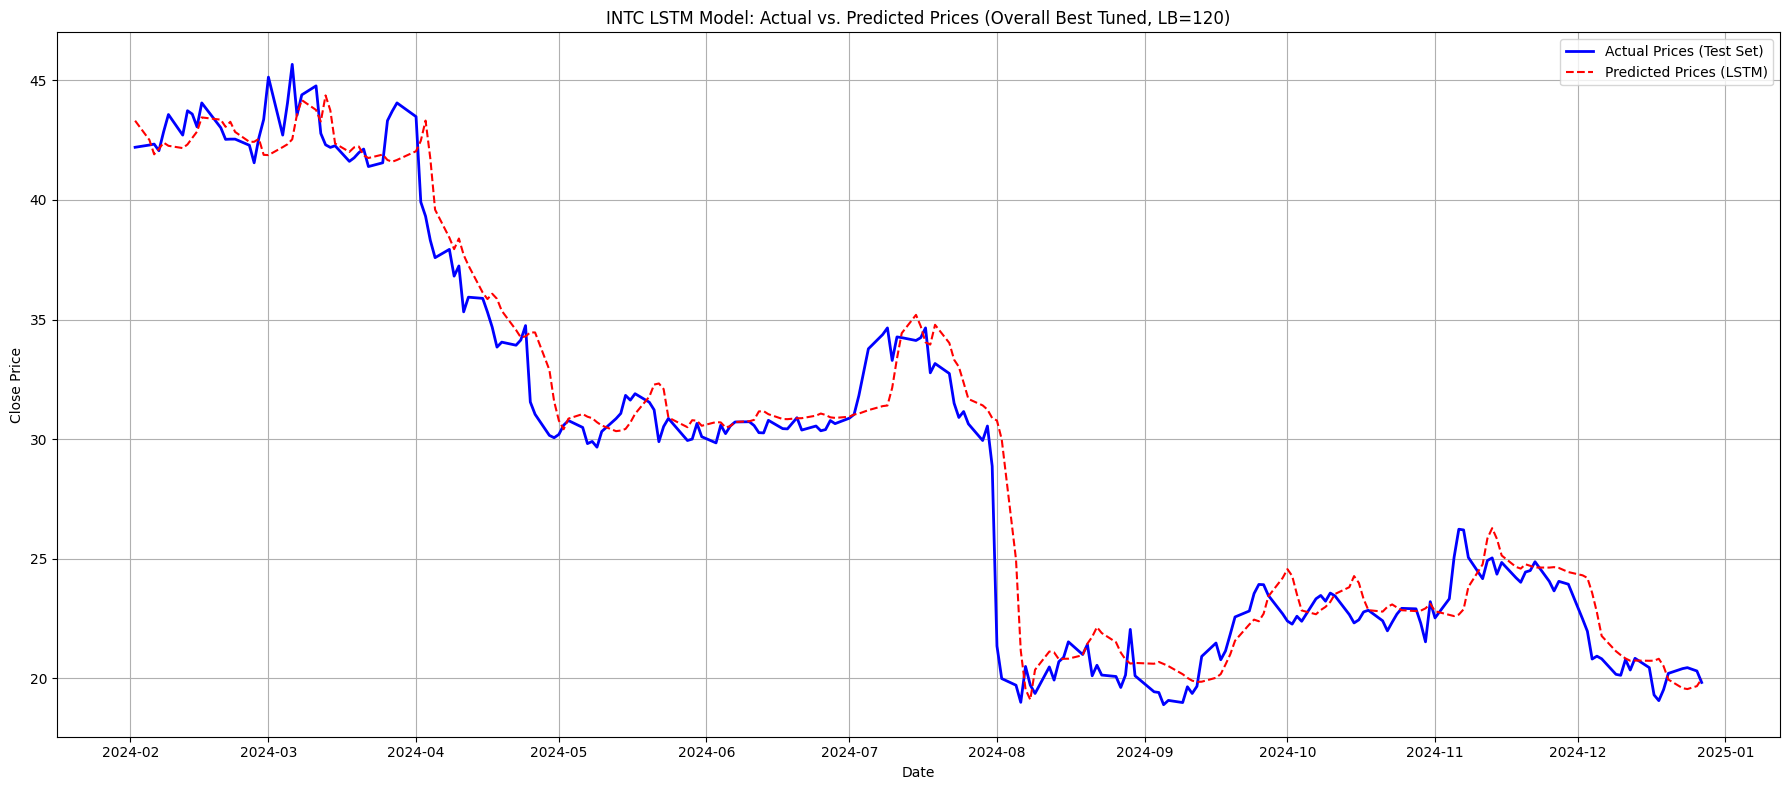


--- LSTM Training History for INTC (Overall Best Tuned, LB=120) ---


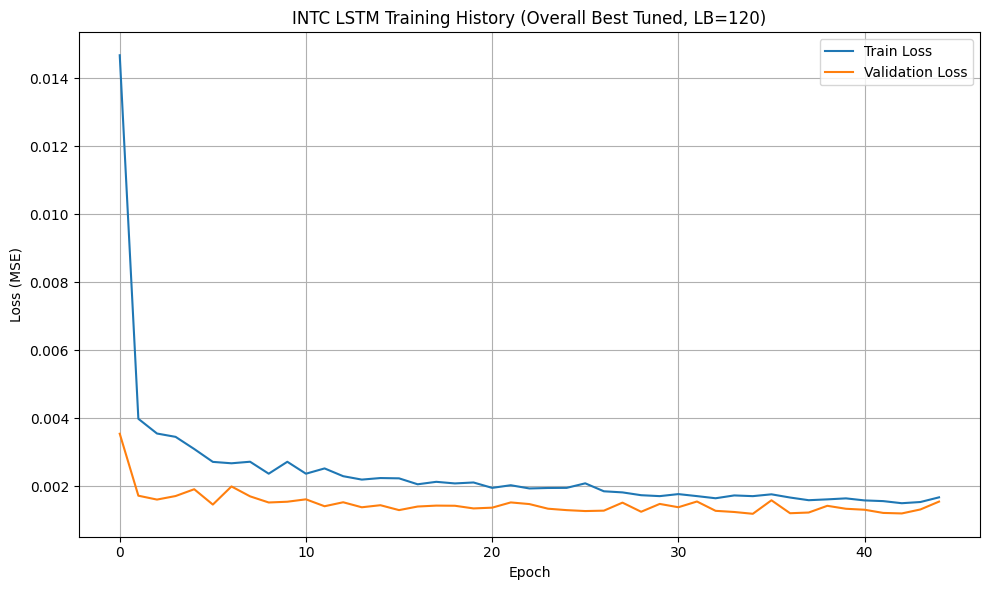


--- Visualizing LSTM Model Predictions for ALL Tickers ---


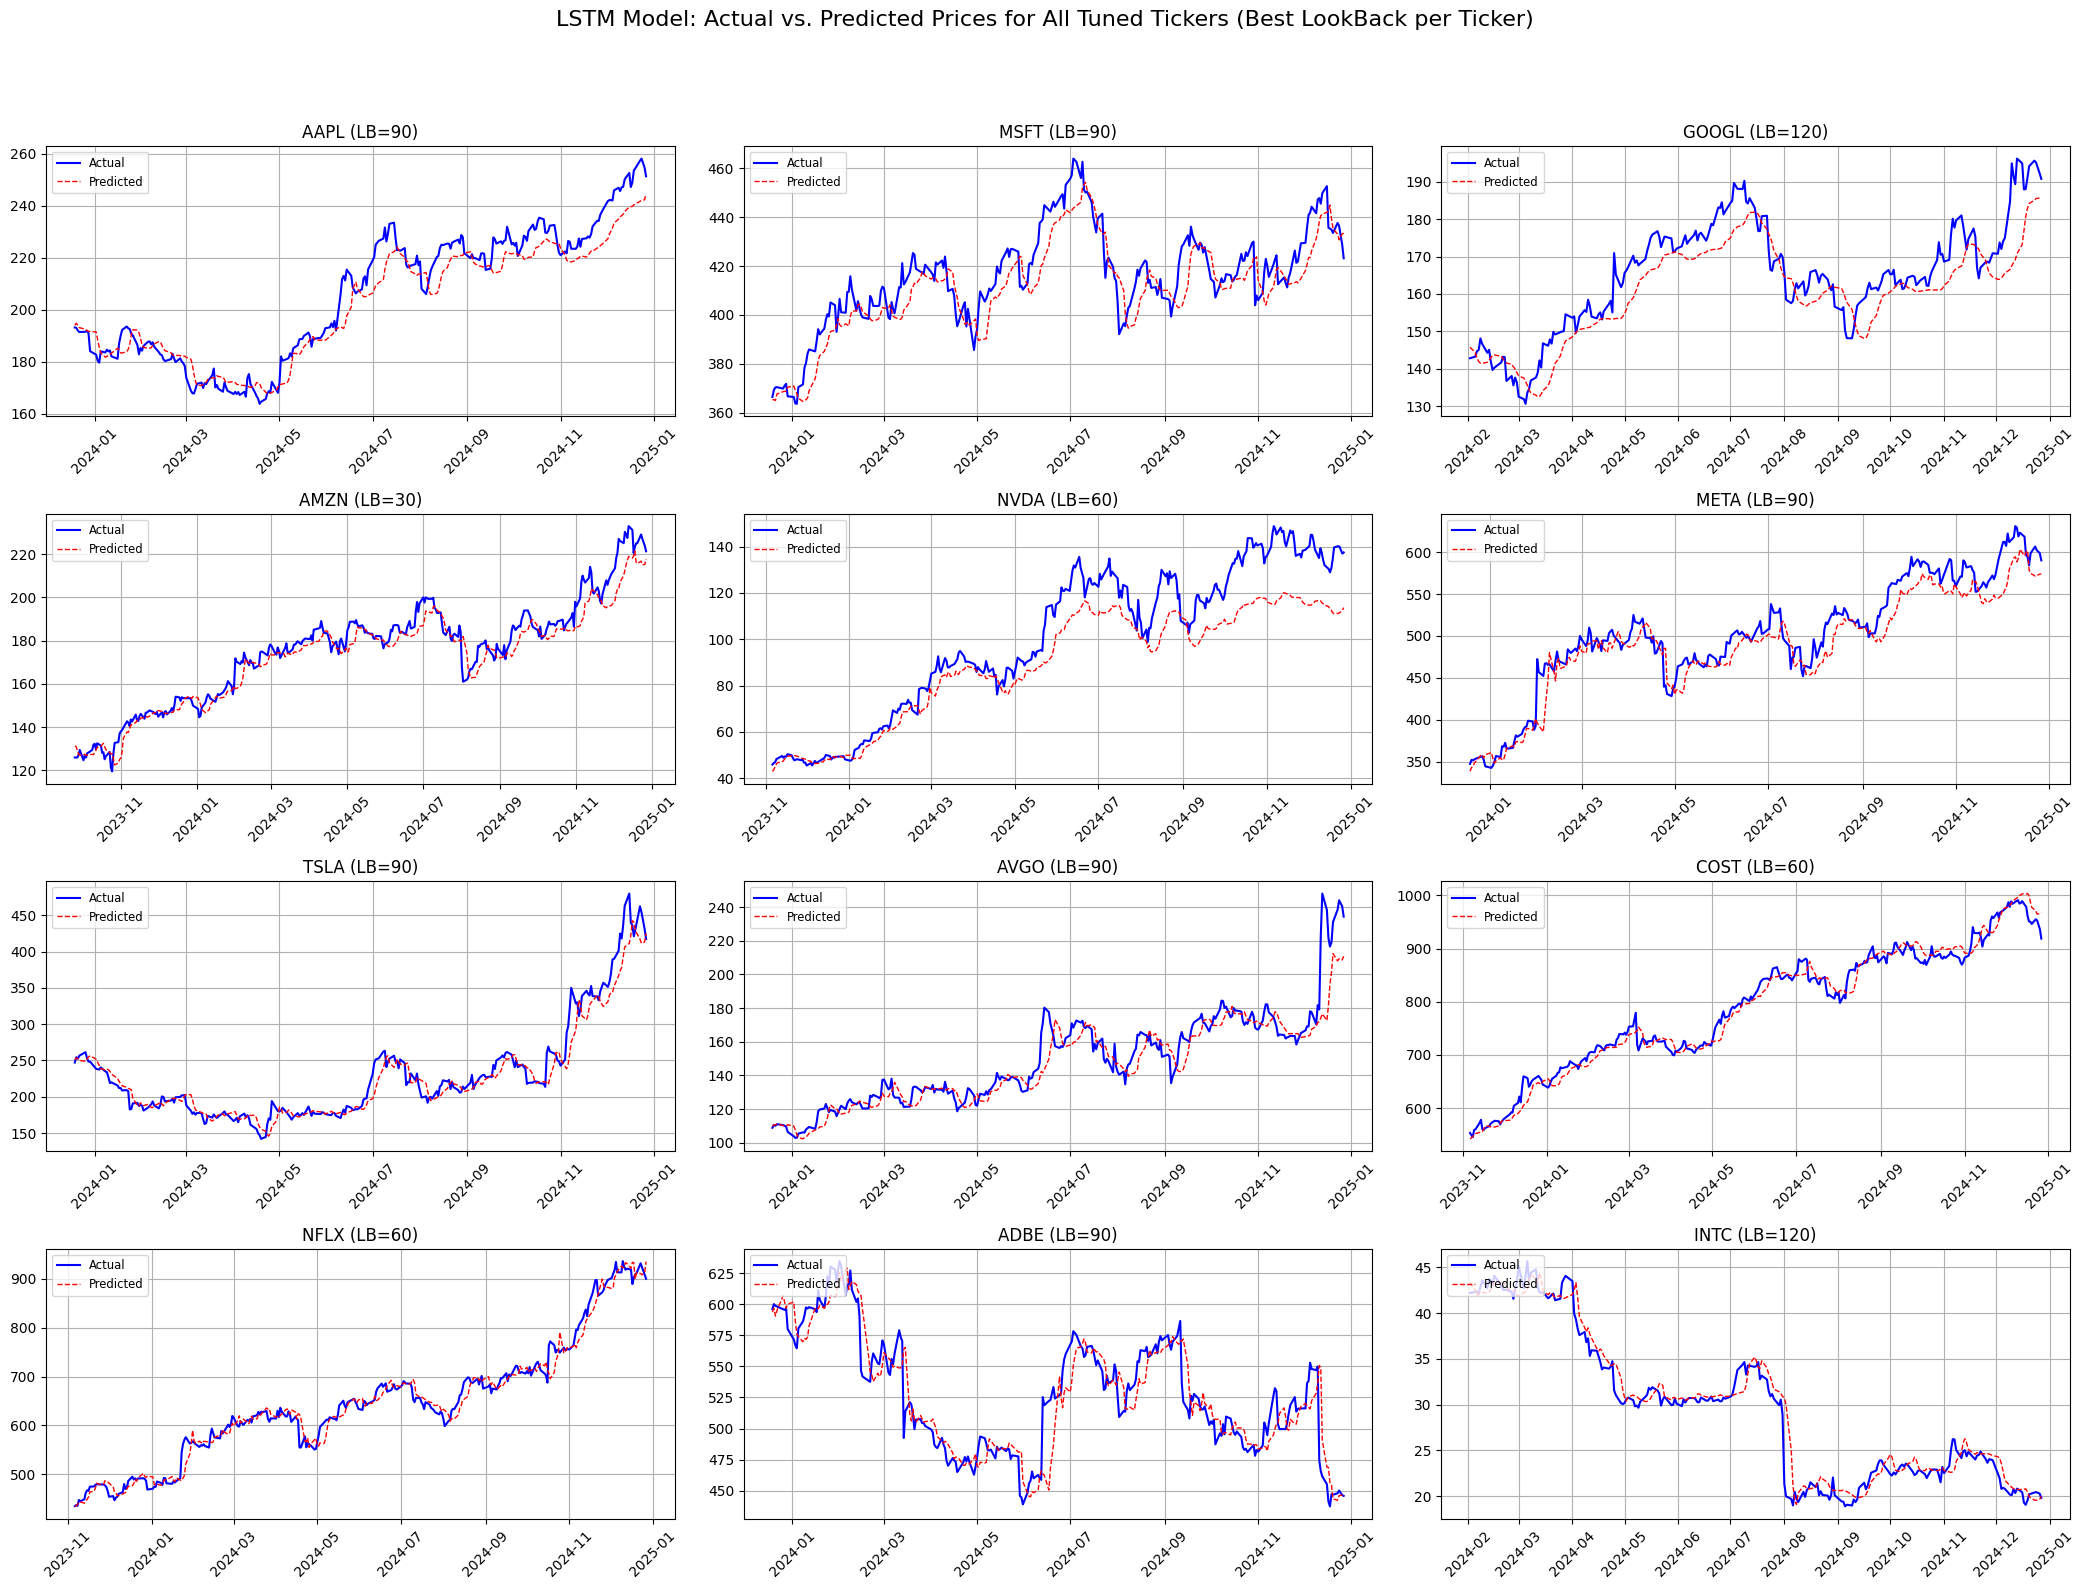

In [ ]:
print("\n Visualizing LSTM Model Predictions")
if overall_best_ticker_val:
    print(f"\n--- Overall Best LSTM Model: Actual vs. Predicted Prices for {overall_best_ticker_val} (LookBack={overall_best_look_back_val}) ---")
    data_for_overall_best_plot = prepared_data_for_all_models['lstm'][overall_best_ticker_val][overall_best_look_back_val]

    y_actual = data_for_overall_best_plot['best_y_actual_lstm_original_scale_for_plot']
    y_predicted = data_for_overall_best_plot['best_y_pred_lstm_original_scale']
    history_to_plot = data_for_overall_best_plot['best_lstm_training_history']

    y_predicted_series = pd.Series(y_predicted.flatten(), index=y_actual.index, name='Predicted Close')

    plt.figure(figsize=(18, 8))
    plt.plot(y_actual.index, y_actual, label='Actual Prices (Test Set)', color='blue', linewidth=2)
    plt.plot(y_predicted_series.index, y_predicted_series, label='Predicted Prices (LSTM)', color='red', linestyle='--', linewidth=1.5)
    plt.title(f'{overall_best_ticker_val} LSTM Model: Actual vs. Predicted Prices (Overall Best Tuned, LB={overall_best_look_back_val})')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, f"{overall_best_ticker_val}_LSTM_Actual_vs_Predicted_OverallBest_LB{overall_best_look_back_val}.png"))
    plt.close()

    print(f"\n LSTM Training History for {overall_best_ticker_val} (Overall Best Tuned, LB={overall_best_look_back_val})")

    plt.figure(figsize=(10, 6))
    plt.plot(history_to_plot['loss'], label='Train Loss')
    plt.plot(history_to_plot['val_loss'], label='Validation Loss')
    plt.title(f'{overall_best_ticker_val} LSTM Training History (Overall Best Tuned, LB={overall_best_look_back_val})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, f"{overall_best_ticker_val}_LSTM_Training_History_OverallBest_LB{overall_best_look_back_val}.png"))
    plt.close()
else:
    print("No overall best LSTM model found for visualization.")


print("\n Visualizing LSTM Model Predictions for ALL Tickers")

all_tuned_lstm_tickers = []
for ticker_name, look_back_data in prepared_data_for_all_models['lstm'].items():
    if look_back_data:
        best_rmse_for_ticker = float('inf')
        best_look_back_for_ticker = None
        for lb, data in look_back_data.items():
            if 'best_rmse' in data and data['best_rmse'] < best_rmse_for_ticker:
                best_rmse_for_ticker = data['best_rmse']
                best_look_back_for_ticker = lb
        if best_look_back_for_ticker is not None:
            all_tuned_lstm_tickers.append((ticker_name, best_look_back_for_ticker, look_back_data[best_look_back_for_ticker]))

if all_tuned_lstm_tickers:
    num_tickers_to_plot = len(all_tuned_lstm_tickers)
    n_cols = 3
    n_rows = math.ceil(num_tickers_to_plot / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 4), squeeze=False)
    axes = axes.flatten()

    for i, (ticker_name, lb, data) in enumerate(all_tuned_lstm_tickers):
        ax = axes[i]
        y_actual = data['best_y_actual_lstm_original_scale_for_plot']
        y_predicted = pd.Series(data['best_y_pred_lstm_original_scale'].flatten(), index=y_actual.index, name='Predicted Close')

        ax.plot(y_actual.index, y_actual, label='Actual', color='blue', linewidth=1.5)
        ax.plot(y_predicted.index, y_predicted, label='Predicted', color='red', linestyle='--', linewidth=1)
        ax.set_title(f'{ticker_name} (LB={lb})')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left', fontsize='small')
        ax.grid(True)

    for j in range(num_tickers_to_plot, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('LSTM Model: Actual vs. Predicted Prices for All Tuned Tickers (Best LookBack per Ticker)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, 'All_Tickers_LSTM_Actual_vs_Predicted_PerTickerBestLB.png'))
    plt.close()
else:
    print("No LSTM model predictions available for plotting all tickers.")

## XGBoost Model

In [ ]:
print("\n\n" + "="*50)
print("     XGBOOST MODEL TRAINING AND EVALUATION")
print("="*50)

# Global best trackers
overall_best_xgb_rmse = float('inf')
overall_best_xgb_ticker = None
overall_best_xgb_params = None

def mean_absolute_percentage_error(y_true, y_pred):
    """Mean Absolute Percentage Error (safe for division by zero)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def objective(trial, X, y):
    """Objective function for Optuna with pruning + adaptive CV."""
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 3000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_bin': trial.suggest_int('max_bin', 128, 512),
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'hist',
        'verbosity': 0
    }

    # Adaptive CV folds
    n_samples = len(X)
    max_splits = max(2, min(5, n_samples // 50))
    tscv = TimeSeriesSplit(n_splits=max_splits)

    rmse_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        # Integrate pruning callback
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f"eval-rmse")

        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=5000,
            evals=[(dval, 'eval')],
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
            verbose_eval=False
        )

        y_pred = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        rmse_scores.append(math.sqrt(mean_squared_error(y_val, y_pred)))

    return np.mean(rmse_scores)


# Training Loop
if not prepared_data_for_all_models.get('xgboost'):
    print("No XGBoost data prepared for any ticker. Skipping training.")
else:
    for ticker, data in prepared_data_for_all_models['xgboost'].items():
        X_train, y_train = data['X_train'], data['y_train']
        X_test, y_test = data['X_test'], data['y_test']

        if X_train.shape[0] < 100 or X_test.shape[0] == 0:
            print(f"Skipping {ticker}: Not enough data.")
            continue

        xgb_model_file_name = f'{ticker}_best_xgboost_model.json'
        xgb_model_path = os.path.join(TRAINED_XGBOOST_MODELS_DIR, xgb_model_file_name)

        if os.path.exists(xgb_model_path) and 'best_y_pred_xgb_original_scale' in data:
            print(f"Loading cached XGBoost model for {ticker}...")
            model = xgb.Booster()
            model.load_model(xgb_model_path)
            y_pred = data['best_y_pred_xgb_original_scale']
            rmse, mae, mape = data['best_xgb_rmse'], data['best_xgb_mae'], data.get('best_xgb_mape', np.nan)
            best_params = data.get('best_xgb_hyperparams', {})
            print(f"  Cached - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        else:
            print(f"\n Hyperparameter tuning for {ticker}")
            try:
                optuna.logging.set_verbosity(optuna.logging.WARNING)
                pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
                study = optuna.create_study(direction='minimize', pruner=pruner)

                # Parallel execution to use all CPU cores
                n_jobs = os.cpu_count() or 4
                study.optimize(
                    lambda trial: objective(trial, X_train, y_train),
                    n_trials=50,
                    n_jobs=n_jobs,    # Run multiple trials in parallel
                    show_progress_bar=False
                )

                best_params = study.best_params
                print(f"  Best params for {ticker}: {best_params}")

                # Retrain on full training data
                dtrain_full = xgb.DMatrix(X_train, label=y_train)
                dtest = xgb.DMatrix(X_test)

                best_model = xgb.train(
                    params={**best_params,
                            'objective': 'reg:squarederror',
                            'n_jobs': -1,
                            'random_state': 42,
                            'tree_method': 'hist',
                            'verbosity': 0},
                    dtrain=dtrain_full,
                    num_boost_round=best_params['n_estimators']
                )

                y_pred = best_model.predict(dtest)
                rmse = math.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                mape = mean_absolute_percentage_error(y_test, y_pred)

                print(f"  Test Results for {ticker} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
                best_model.save_model(xgb_model_path)
                print(f"  Model saved: {xgb_model_path}")

            except Exception as e:
                print(f"  Error for {ticker}: {e}")
                continue

        # Save results
        data['best_y_pred_xgb_original_scale'] = y_pred
        data['best_y_actual_xgb_original_scale_for_plot'] = y_test
        data['best_xgb_rmse'] = rmse
        data['best_xgb_mae'] = mae
        data['best_xgb_mape'] = mape
        data['best_xgb_hyperparams'] = best_params

        if rmse < overall_best_xgb_rmse:
            overall_best_xgb_rmse, overall_best_xgb_ticker, overall_best_xgb_params = rmse, ticker, best_params

print("\n" + "="*80)
print("                         XGBOOST MODEL TRAINING COMPLETE")
print("="*80)

if overall_best_xgb_ticker:
    print(f"\nBest RMSE: {overall_best_xgb_rmse:.4f} for {overall_best_xgb_ticker}")
    best_mape_value = prepared_data_for_all_models['xgboost'][overall_best_xgb_ticker].get('best_xgb_mape', np.nan)
    print(f"Best MAPE: {best_mape_value:.2f}% for {overall_best_xgb_ticker}")
else:
    print("No successful XGBoost training occurred.")

# Save updated data
if any(prepared_data_for_all_models['xgboost'].values()):
    with open(PREPARED_DATA_PKL_PATH, 'wb') as f:
        pickle.dump(prepared_data_for_all_models, f)
    print(f"\nSaved updated results to {PREPARED_DATA_PKL_PATH}")
else:
    print("\nNothing to save. No XGBoost models trained.")





     XGBOOST MODEL TRAINING AND EVALUATION (Optuna)

--- Hyperparameter tuning for AAPL ---
  Best params for AAPL: {'n_estimators': 2800, 'max_depth': 13, 'learning_rate': 0.25247831783266944, 'min_child_weight': 5, 'gamma': 1.7514385209158967, 'reg_alpha': 0.02528589882395392, 'reg_lambda': 1.0856753268961576, 'colsample_bytree': 0.999538178542431, 'subsample': 0.8829138579505491, 'max_bin': 284}
  Test Results for AAPL → RMSE: 42.9068, MAE: 35.3195, MAPE: 16.31%
  Model saved: /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/trained_xgboost_models/AAPL_best_xgboost_model.json

--- Hyperparameter tuning for MSFT ---
  Best params for MSFT: {'n_estimators': 700, 'max_depth': 12, 'learning_rate': 0.061324045003541376, 'min_child_weight': 7, 'gamma': 1.4307357715862024, 'reg_alpha': 0.12393891193765079, 'reg_lambda': 1.0641265331804313, 'colsample_bytree': 0.6524813568519756, 'subsample': 0.8967697031862751, 'max_bin': 397}
  Test Results for MSFT → RMSE: 86.48

### XGBoost Visualizations


--- Visualizing XGBoost Model Predictions ---

--- Overall Best XGBoost Model: Actual vs. Predicted Prices for INTC ---


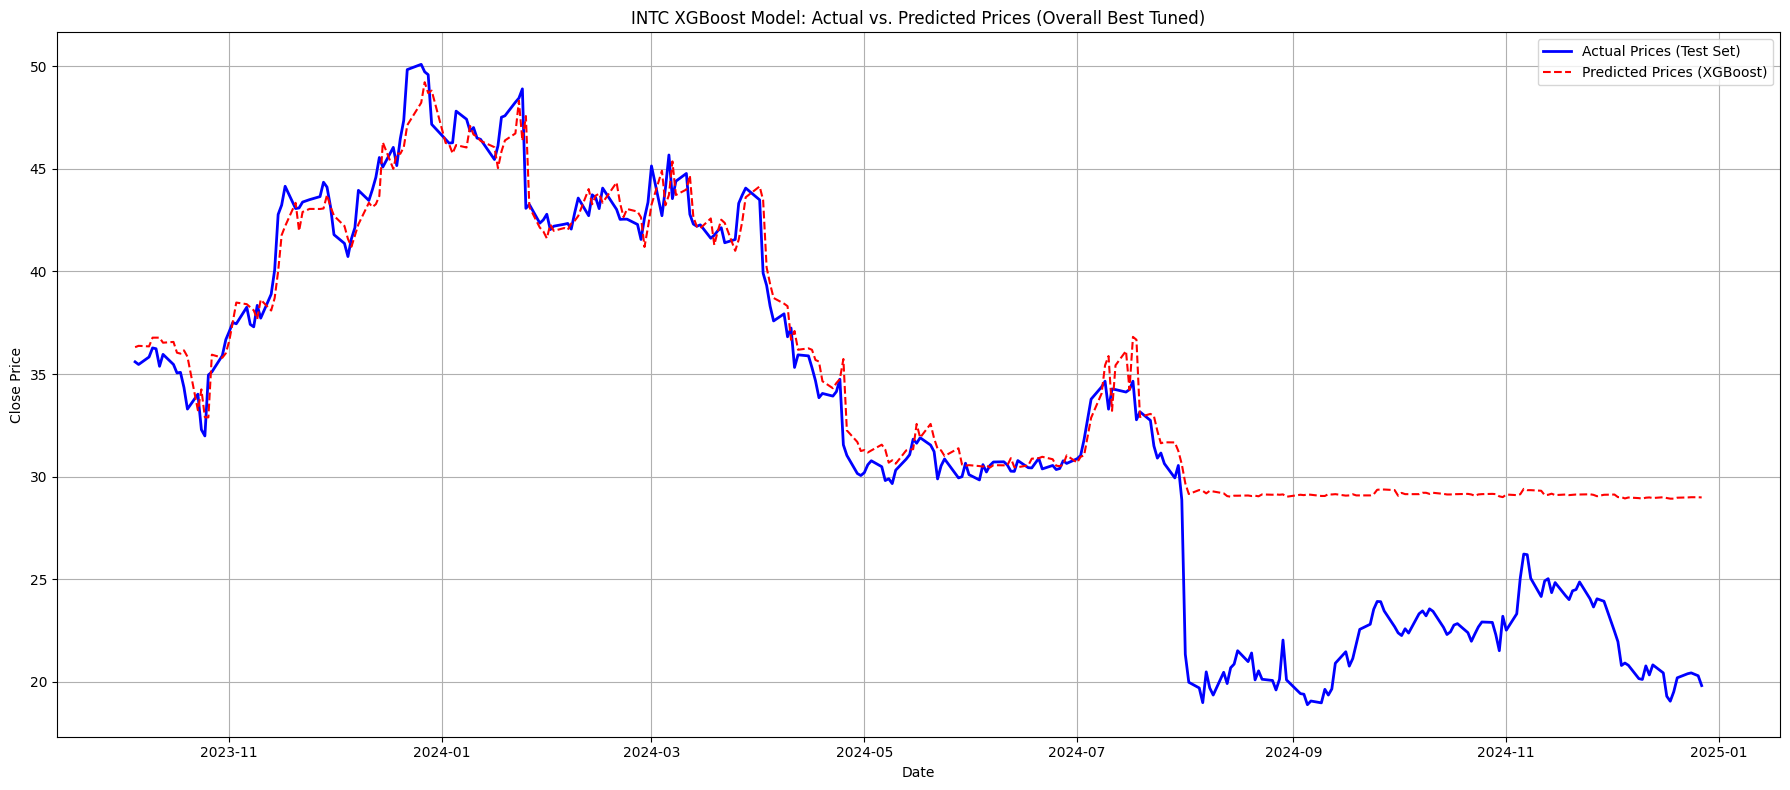


--- Visualizing XGBoost Model Predictions for ALL Tickers ---


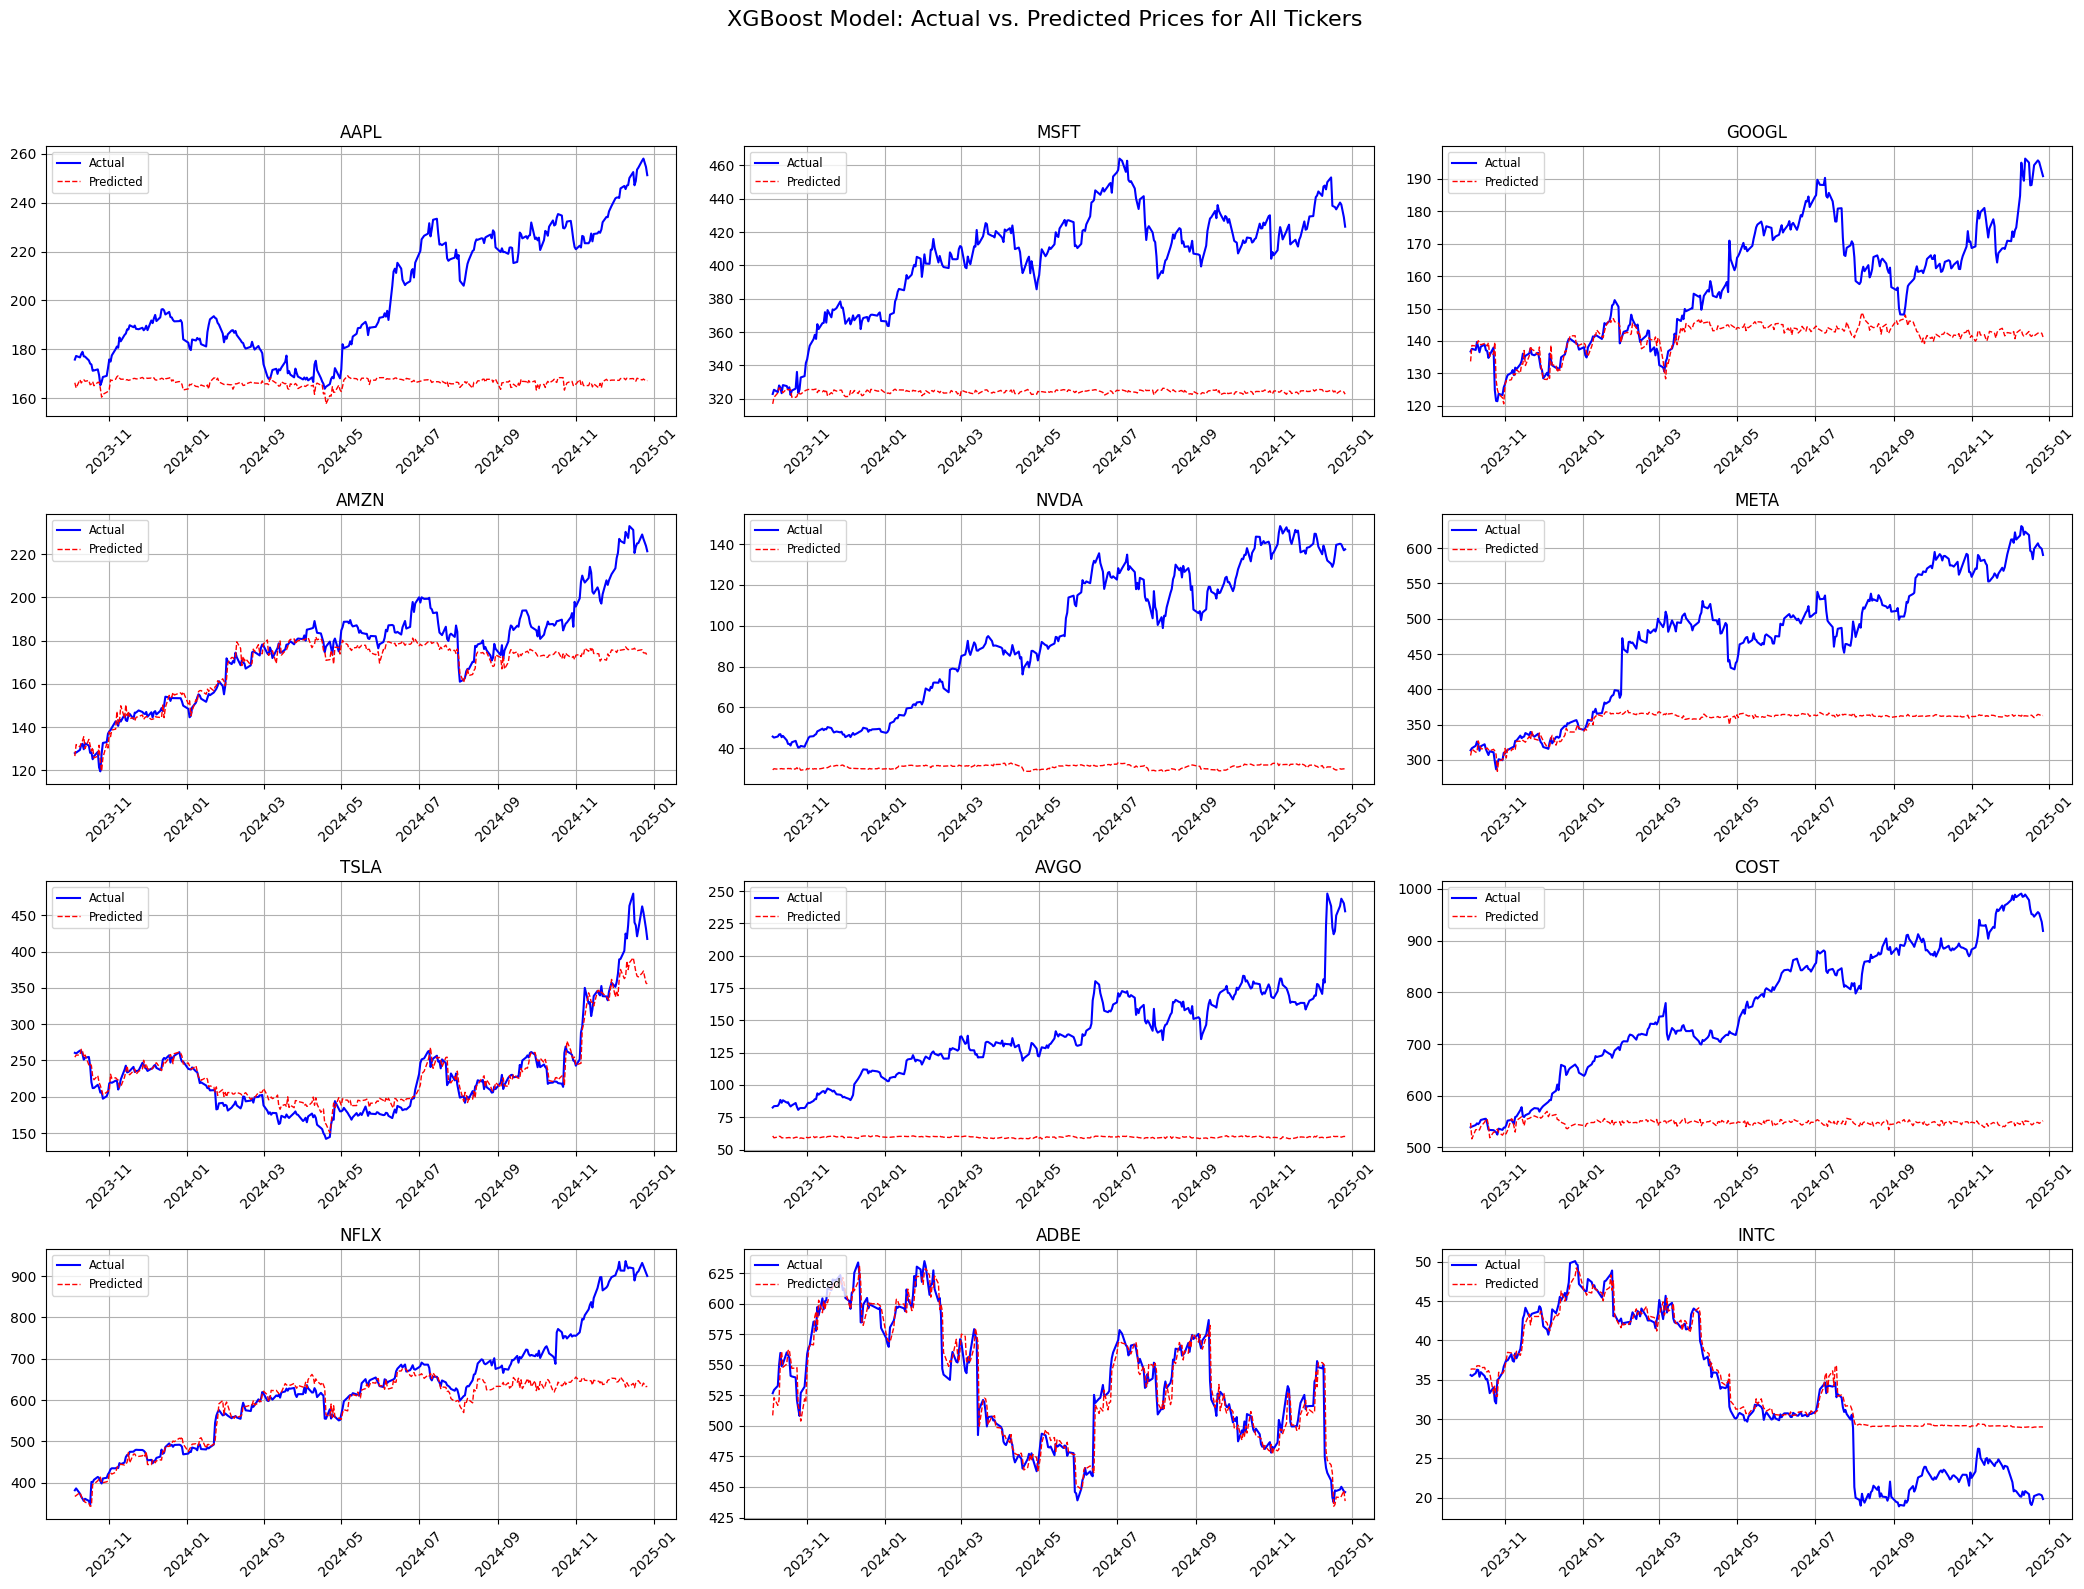

In [ ]:
print("\n Visualizing XGBoost Model Predictions")
if overall_best_xgb_ticker:
    print(f"\n Overall Best XGBoost Model: Actual vs. Predicted Prices for {overall_best_xgb_ticker}")
    data_for_overall_best_plot = prepared_data_for_all_models['xgboost'][overall_best_xgb_ticker]
    y_actual = data_for_overall_best_plot['best_y_actual_xgb_original_scale_for_plot']
    y_predicted = pd.Series(data_for_overall_best_plot['best_y_pred_xgb_original_scale'], index=y_actual.index, name='Predicted Close')
    plt.figure(figsize=(18, 8))
    plt.plot(y_actual.index, y_actual, label='Actual Prices (Test Set)', color='blue', linewidth=2)
    plt.plot(y_predicted.index, y_predicted, label='Predicted Prices (XGBoost)', color='red', linestyle='--', linewidth=1.5)
    plt.title(f'{overall_best_xgb_ticker} XGBoost Model: Actual vs. Predicted Prices (Overall Best Tuned)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, f"{overall_best_xgb_ticker}_XGBoost_Actual_vs_Predicted_OverallBest.png"))
    plt.close()
else:
    print("No overall best XGBoost model found for visualization.")
print("\n Visualizing XGBoost Model Predictions for ALL Tickers")
all_xgboost_tickers = []
for ticker_name, data in prepared_data_for_all_models['xgboost'].items():
    if 'best_y_pred_xgb_original_scale' in data and data['best_y_actual_xgb_original_scale_for_plot'].shape[0] > 0:
        all_xgboost_tickers.append((ticker_name, data))
if all_xgboost_tickers:
    num_tickers_to_plot = len(all_xgboost_tickers)
    n_cols = 3
    n_rows = math.ceil(num_tickers_to_plot / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 4), squeeze=False)
    axes = axes.flatten()
    for i, (ticker_name, data) in enumerate(all_xgboost_tickers):
        ax = axes[i]
        y_actual = data['best_y_actual_xgb_original_scale_for_plot']
        y_predicted = pd.Series(data['best_y_pred_xgb_original_scale'], index=y_actual.index, name='Predicted Close')
        ax.plot(y_actual.index, y_actual, label='Actual', color='blue', linewidth=1.5)
        ax.plot(y_predicted.index, y_predicted, label='Predicted', color='red', linestyle='--', linewidth=1)
        ax.set_title(f'{ticker_name}')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left', fontsize='small')
        ax.grid(True)
    for j in range(num_tickers_to_plot, len(axes)):
        axes[j].set_visible(False)
    plt.suptitle('XGBoost Model: Actual vs. Predicted Prices for All Tickers', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, 'All_Tickers_XGBoost_Actual_vs_Predicted.png'))
    plt.close()
else:
    print("No XGBoost model predictions available for plotting all tickers.")


## ARIMAX Model

In [ ]:
print("\n\n" + "=" * 80)
print("     PARALLEL ARIMAX MODEL TRAINING AND EVALUATION")
print("=" * 80)

overall_best_arima_rmse = float('inf')
overall_best_arima_ticker = None
overall_best_arima_order = None

ARIMA_AUTO_PARAMS = {
    'start_p': 0, 'max_p': 3,
    'start_q': 0, 'max_q': 3,
    'max_d': 2,
    'start_P': 0, 'max_P': 1,
    'start_Q': 0, 'max_Q': 1,
    'm': 5,
    'seasonal': True,
    'stepwise': True,
    'suppress_warnings': True,
    'trace': False,
    'error_action': 'ignore',
    'n_jobs': 1
}

def train_single_arima(ticker, data):
    model_path = os.path.join(TRAINED_ARIMA_MODELS_DIR, f"{ticker}_best_arima_model.pkl")

    train_data = data['train_data']
    test_data = data['test_data']
    train_exog = data['train_exog']
    test_exog = data['test_exog']
    adf_p_value = data['adf_p_value']

    if train_data.empty or test_data.empty:
        return ticker, None, None, None, None, None, None, None, "Insufficient data"

    # Load pre-trained if exists
    if os.path.exists(model_path) and 'best_y_pred_arima_original_scale' in data:
        with open(model_path, 'rb') as f:
            arima_model_fit = pickle.load(f)
        y_pred = data['best_y_pred_arima_original_scale']
        rmse = data['best_arima_rmse']
        mae = data['best_arima_mae']
        mape = data.get('best_arima_mape', np.nan)
        best_order = data['best_arima_order']
        best_seasonal_order = data['best_arima_seasonal_order']
        return ticker, y_pred, rmse, mae, mape, best_order, best_seasonal_order, test_data, "Loaded from disk"

    # Train new model
    try:
        d_val = 1 if adf_p_value > 0.05 else 0
        stepwise_fit = auto_arima(y=train_data, X=train_exog, d=d_val, **ARIMA_AUTO_PARAMS)

        best_order = stepwise_fit.order
        best_seasonal_order = stepwise_fit.seasonal_order

        # Refit & predict
        arima_model_fit = stepwise_fit.fit(y=train_data, X=train_exog)
        y_pred_forecast = arima_model_fit.predict(n_periods=len(test_data), X=test_exog)
        y_pred_forecast.index = test_data.index
        y_pred = y_pred_forecast.values

        rmse = math.sqrt(mean_squared_error(test_data, y_pred))
        mae = mean_absolute_error(test_data, y_pred)
        mape = mean_absolute_percentage_error(test_data, y_pred)

        with open(model_path, 'wb') as f:
            pickle.dump(arima_model_fit, f)

        return ticker, y_pred, rmse, mae, mape, best_order, best_seasonal_order, test_data, "Trained"

    except Exception as e:
        return ticker, None, None, None, None, None, None, None, f"Error: {e}"

# Run all tickers in parallel
if prepared_data_for_all_models.get('arima'):
    # Run all tickers in parallel
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(train_single_arima)(ticker, data)
        for ticker, data in prepared_data_for_all_models['arima'].items()
    )

    # Process and print results from the parallel run
    for res in results:
        ticker, y_pred, rmse, mae, mape, best_order, best_seasonal_order, test_data, status = res

        # Print a summary of the result for each ticker
        if status.startswith("Error"):
            print(f"[{ticker}] {status}")
            continue
        elif status == "Insufficient data":
            print(f"[{ticker}] {status}")
            continue
        elif status == "Loaded from disk":
            print(f"[{ticker}] Loaded from disk | Order: {best_order}, Seasonal: {best_seasonal_order} | RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
        elif status == "Trained":
            print(f"[{ticker}] Trained | Order: {best_order}, Seasonal: {best_seasonal_order} | RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

        # Save back into prepared_data_for_all_models
        pd_data = prepared_data_for_all_models['arima'][ticker]
        pd_data['best_y_pred_arima_original_scale'] = y_pred
        pd_data['best_y_actual_arima_original_scale_for_plot'] = test_data
        pd_data['best_arima_rmse'] = rmse
        pd_data['best_arima_mae'] = mae
        pd_data['best_arima_mape'] = mape
        pd_data['best_arima_order'] = best_order
        pd_data['best_arima_seasonal_order'] = best_seasonal_order

        # Track global best
        if rmse < overall_best_arima_rmse:
            overall_best_arima_rmse = rmse
            overall_best_arima_ticker = ticker
            overall_best_arima_order = best_order

    # Summary
    print("\n" + "=" * 80)
    print("             PARALLEL ARIMA MODEL TRAINING COMPLETE.")
    print("=" * 80)

    if overall_best_arima_ticker:
        print(f"Best Overall: {overall_best_arima_ticker} | "
              f"RMSE: {overall_best_arima_rmse:.4f} | Order: {overall_best_arima_order} | "
              f"MAPE: {prepared_data_for_all_models['arima'][overall_best_arima_ticker]['best_arima_mape']:.2f}%")
    else:
        print("No successful ARIMA runs.")

    # Save updated prepared_data
    if any(prepared_data_for_all_models['arima'].values()):
        with open(PREPARED_DATA_PKL_PATH, 'wb') as f:
            pickle.dump(prepared_data_for_all_models, f)
        print(f"Updated predictions saved → {PREPARED_DATA_PKL_PATH}")



     PARALLEL ARIMA MODEL TRAINING AND EVALUATION
[AAPL] Trained | Order: (0, 1, 2), Seasonal: (1, 0, 1, 5) | RMSE: 4.8015, MAE: 4.0350, MAPE: 1.99%
[MSFT] Trained | Order: (0, 1, 1), Seasonal: (0, 0, 0, 5) | RMSE: 7.6671, MAE: 6.5221, MAPE: 1.63%
[GOOGL] Trained | Order: (0, 1, 1), Seasonal: (1, 0, 0, 5) | RMSE: 2.9978, MAE: 2.2448, MAPE: 1.46%
[AMZN] Trained | Order: (0, 1, 2), Seasonal: (1, 0, 1, 5) | RMSE: 4.6413, MAE: 3.6098, MAPE: 2.04%
[NVDA] Trained | Order: (3, 1, 1), Seasonal: (0, 0, 1, 5) | RMSE: 3.8219, MAE: 2.9428, MAPE: 3.13%
[META] Trained | Order: (0, 1, 1), Seasonal: (1, 0, 1, 5) | RMSE: 14.4924, MAE: 11.3269, MAPE: 2.48%
[TSLA] Trained | Order: (0, 1, 2), Seasonal: (1, 0, 1, 5) | RMSE: 11.8647, MAE: 8.2356, MAPE: 3.36%
[AVGO] Trained | Order: (3, 1, 1), Seasonal: (1, 0, 0, 5) | RMSE: 7.4802, MAE: 5.5146, MAPE: 3.77%
[COST] Trained | Order: (0, 1, 2), Seasonal: (1, 0, 1, 5) | RMSE: 34.2300, MAE: 27.3980, MAPE: 3.32%
[NFLX] Trained | Order: (0, 1, 2), Seasonal: (1, 0,

### ARIMA Visualization


--- Visualizing ARIMA Model Predictions ---

--- Overall Best ARIMA Model: Actual vs. Predicted Prices for INTC ---


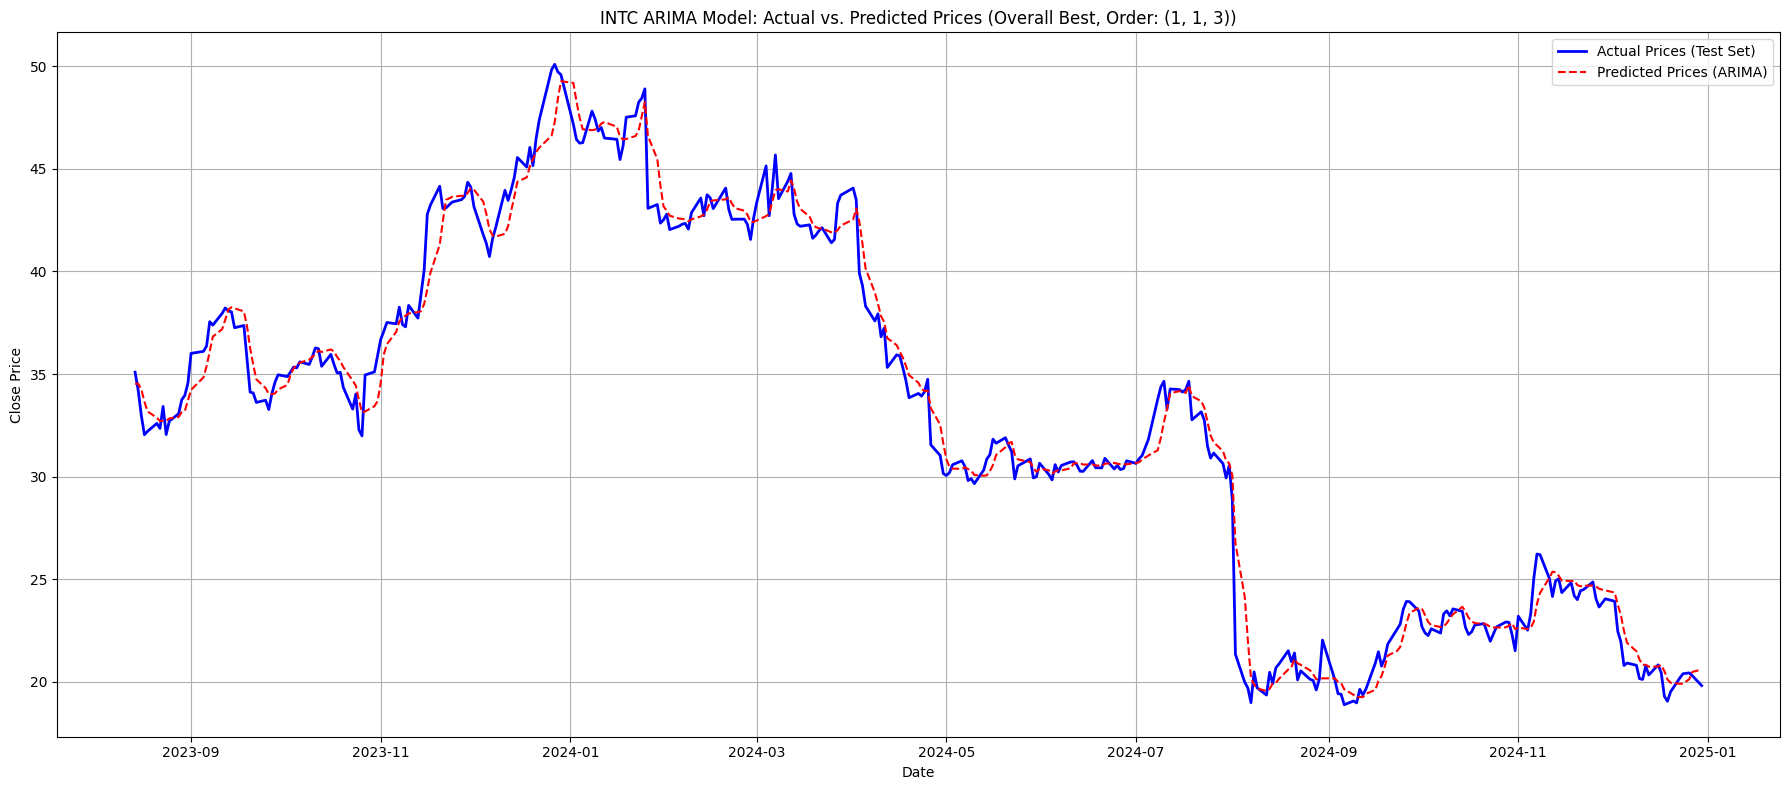


--- Visualizing ARIMA Model Predictions for ALL Tickers ---


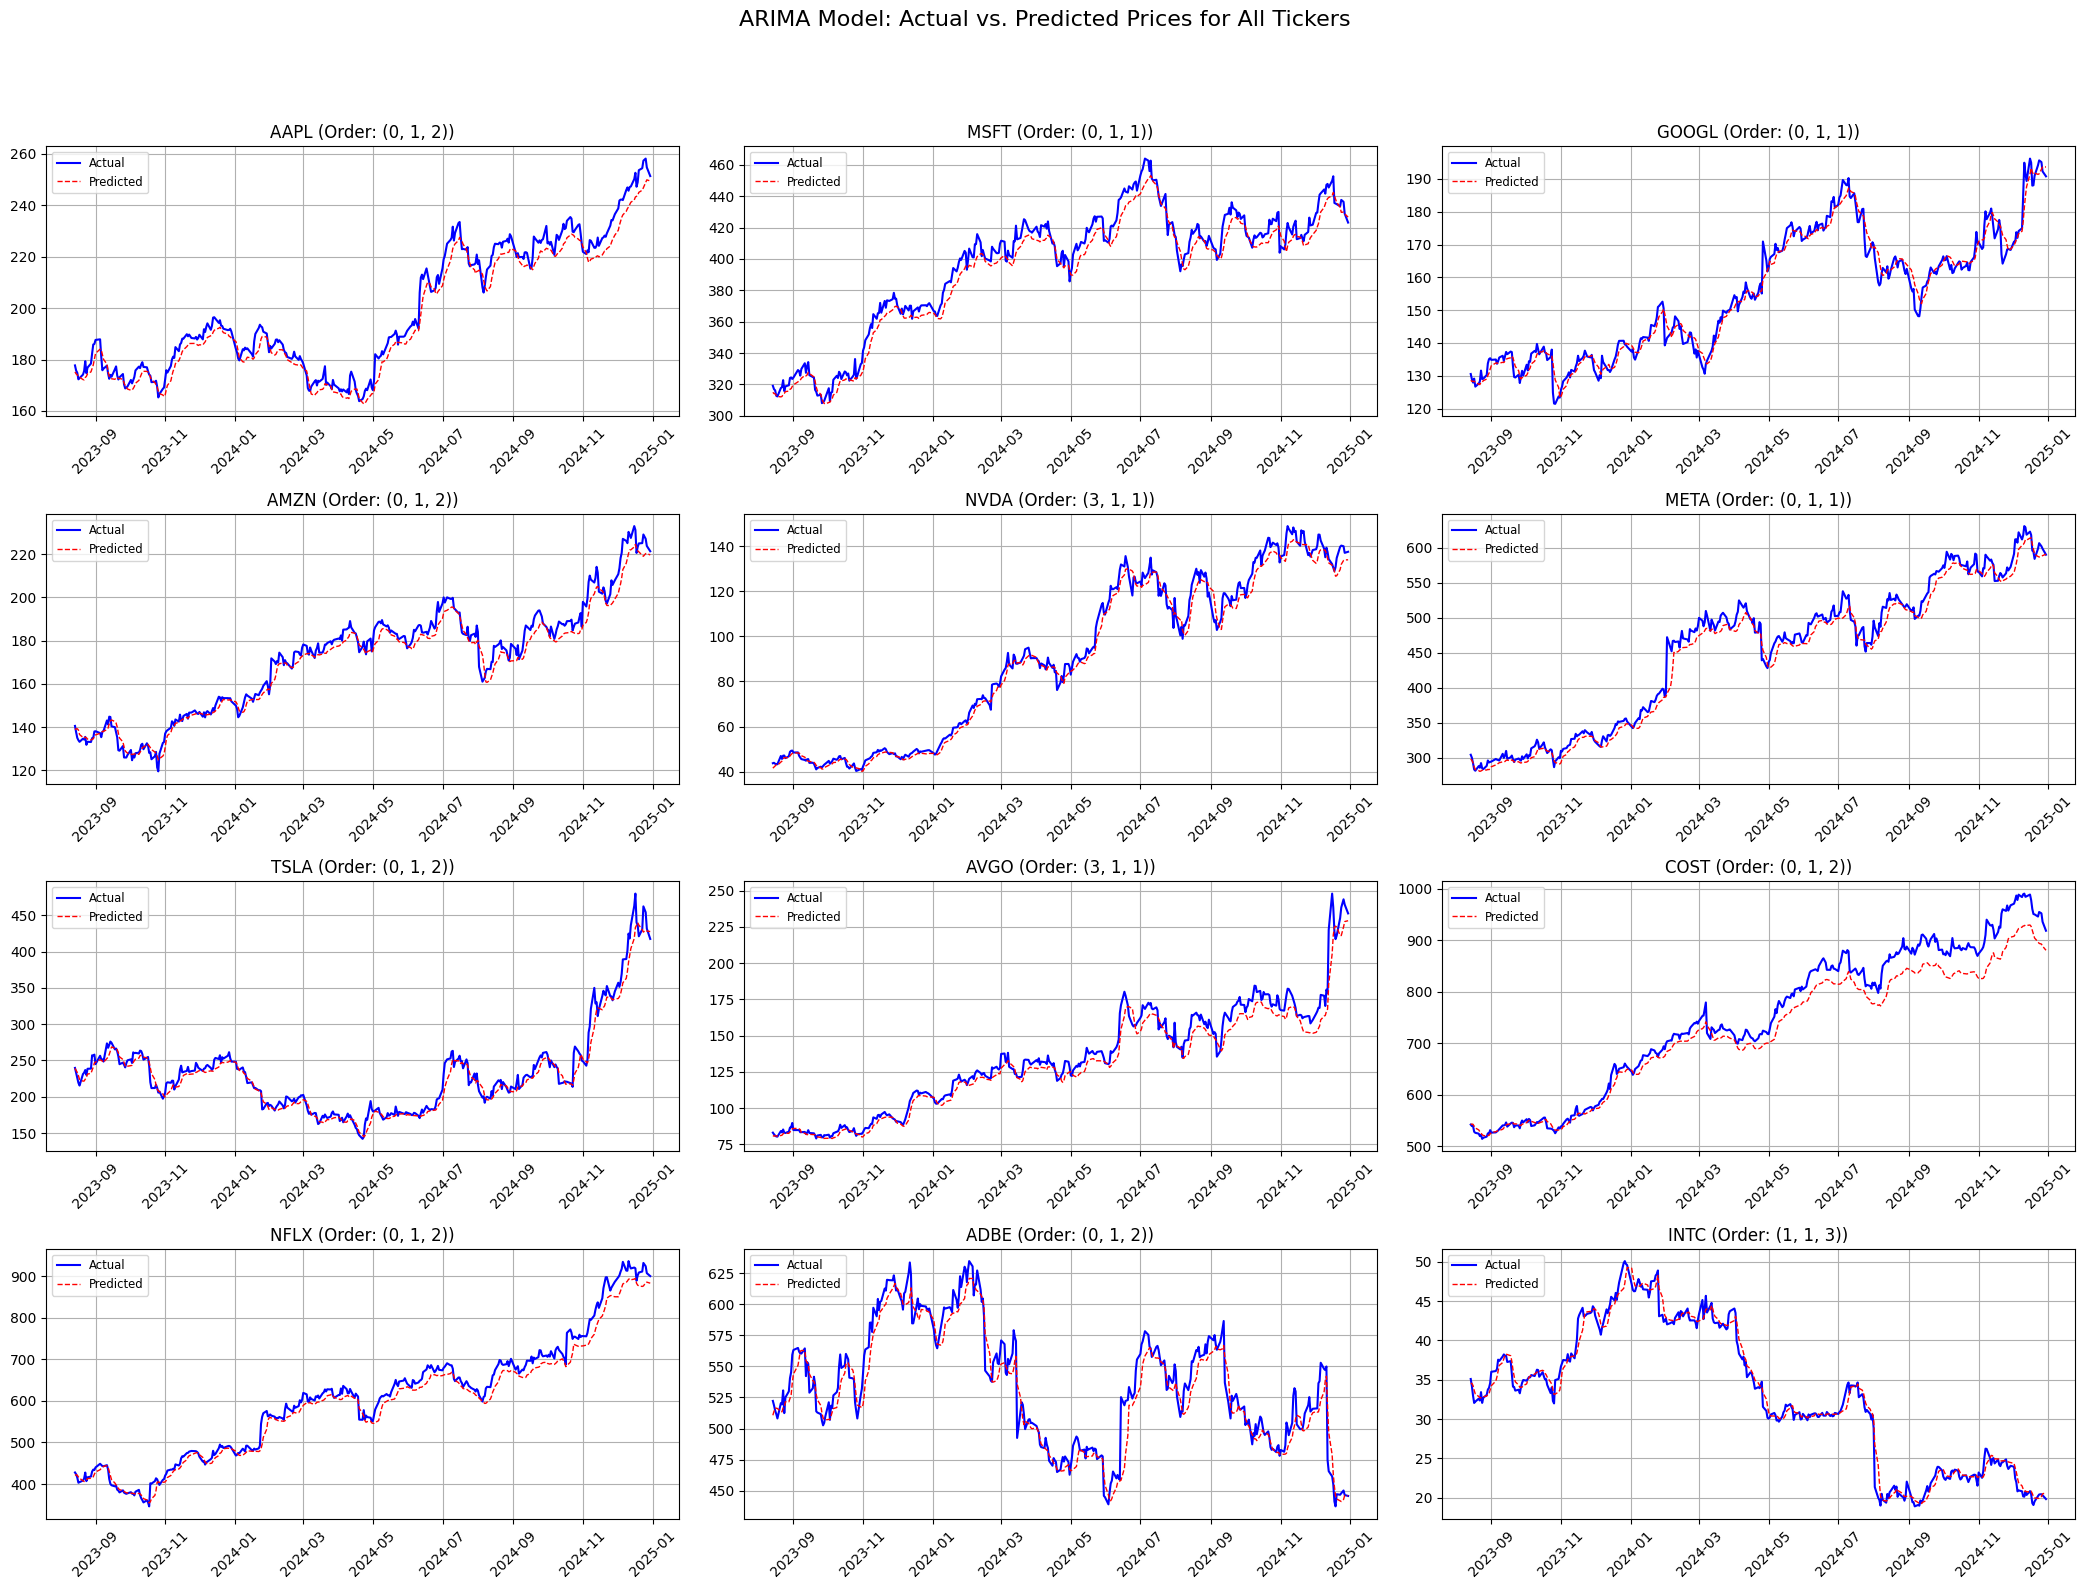

In [ ]:
print("\n Visualizing ARIMA Model Predictions")
if overall_best_arima_ticker:
    print(f"\n Overall Best ARIMA Model: Actual vs. Predicted Prices for {overall_best_arima_ticker}")
    data_for_overall_best_plot = prepared_data_for_all_models['arima'][overall_best_arima_ticker]
    y_actual = data_for_overall_best_plot['best_y_actual_arima_original_scale_for_plot']
    y_predicted = pd.Series(data_for_overall_best_plot['best_y_pred_arima_original_scale'], index=y_actual.index, name='Predicted Close')
    plt.figure(figsize=(18, 8))
    plt.plot(y_actual.index, y_actual, label='Actual Prices (Test Set)', color='blue', linewidth=2)
    plt.plot(y_predicted.index, y_predicted, label='Predicted Prices (ARIMA)', color='red', linestyle='--', linewidth=1.5)
    plt.title(f'{overall_best_arima_ticker} ARIMA Model: Actual vs. Predicted Prices (Overall Best, Order: {overall_best_arima_order})')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, f"{overall_best_arima_ticker}_ARIMA_Actual_vs_Predicted_OverallBest.png"))
    plt.close()
else:
    print("No overall best ARIMA model found for visualization.")
print("\n Visualizing ARIMA Model Predictions for ALL Tickers")
all_arima_tickers = []
for ticker_name, data in prepared_data_for_all_models['arima'].items():
    if 'best_y_pred_arima_original_scale' in data and data['best_y_actual_arima_original_scale_for_plot'].shape[0] > 0:
        all_arima_tickers.append((ticker_name, data))
if all_arima_tickers:
    num_tickers_to_plot = len(all_arima_tickers)
    n_cols = 3
    n_rows = math.ceil(num_tickers_to_plot / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 4), squeeze=False)
    axes = axes.flatten()
    for i, (ticker_name, data) in enumerate(all_arima_tickers):
        ax = axes[i]
        y_actual = data['best_y_actual_arima_original_scale_for_plot']
        y_predicted = pd.Series(data['best_y_pred_arima_original_scale'], index=y_actual.index, name='Predicted Close')
        ax.plot(y_actual.index, y_actual, label='Actual', color='blue', linewidth=1.5)
        ax.plot(y_predicted.index, y_predicted, label='Predicted', color='red', linestyle='--', linewidth=1)
        ax.set_title(f'{ticker_name} (Order: {data["best_arima_order"]})')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(loc='upper left', fontsize='small')
        ax.grid(True)
    for j in range(num_tickers_to_plot, len(axes)):
        axes[j].set_visible(False)
    plt.suptitle('ARIMA Model: Actual vs. Predicted Prices for All Tickers', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
    plt.savefig(os.path.join(Plots_Output_Path, 'All_Tickers_ARIMA_Actual_vs_Predicted.png'))
    plt.close()
else:
    print("No ARIMA model predictions available for plotting all tickers.")


## Compare Results Accross Models

In [ ]:
# Load the prepared data dictionary
try:
    with open(PREPARED_DATA_PKL_PATH, 'rb') as f:
        prepared_data_for_all_models = pickle.load(f)
    print("Prepared data loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file {PREPARED_DATA_PKL_PATH} was not found.")
    print("Please ensure your main script has run and saved the data.")
    prepared_data_for_all_models = {'lstm': {}, 'xgboost': {}, 'arima': {}}


results = []
for ticker in Tickers:
    ticker_results = {
        'Ticker': ticker,
        'Best_LSTM_RMSE': np.nan, 'Best_LSTM_MAE': np.nan,
        'Best_XGB_RMSE': np.nan, 'Best_XGB_MAE': np.nan, 'Best_XGB_MAPE': np.nan,
        'Best_ARIMA_RMSE': np.nan, 'Best_ARIMA_MAE': np.nan, 'Best_ARIMA_MAPE': np.nan
    }

    # Retrieve Best LSTM Metrics
    if ticker in prepared_data_for_all_models['lstm'] and prepared_data_for_all_models['lstm'][ticker]:
        best_lstm_rmse = float('inf')
        for lb, data in prepared_data_for_all_models['lstm'][ticker].items():
            if 'best_rmse' in data and data['best_rmse'] < best_lstm_rmse:
                best_lstm_rmse = data['best_rmse']
                ticker_results['Best_LSTM_RMSE'] = data.get('best_rmse')
                ticker_results['Best_LSTM_MAE'] = data.get('best_mae')

    # Retrieve XGBoost Metrics
    if ticker in prepared_data_for_all_models['xgboost']:
        data = prepared_data_for_all_models['xgboost'][ticker]
        ticker_results['Best_XGB_RMSE'] = data.get('best_xgb_rmse')
        ticker_results['Best_XGB_MAE'] = data.get('best_xgb_mae')
        ticker_results['Best_XGB_MAPE'] = data.get('best_xgb_mape')

    # Retrieve ARIMA Metrics
    if ticker in prepared_data_for_all_models['arima']:
        data = prepared_data_for_all_models['arima'][ticker]
        ticker_results['Best_ARIMA_RMSE'] = data.get('best_arima_rmse')
        ticker_results['Best_ARIMA_MAE'] = data.get('best_arima_mae')
        ticker_results['Best_ARIMA_MAPE'] = data.get('best_arima_mape')

    results.append(ticker_results)


results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("                   FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)
print("\nModel Performance Comparison (RMSE, MAE, and MAPE):")
print(results_df.to_string())

print("\n" + "="*80)
print("             OVERALL WINNER BY METRIC")
print("="*80)

print("\nBest Performing Model by RMSE:")
best_model_by_rmse = results_df.set_index('Ticker')[['Best_LSTM_RMSE', 'Best_XGB_RMSE', 'Best_ARIMA_RMSE']].idxmin(axis=1)
print(pd.DataFrame({'Best_Model_by_RMSE': best_model_by_rmse}))

print("\nBest Performing Model by MAPE:")
best_model_by_mape = results_df.set_index('Ticker')[['Best_XGB_MAPE', 'Best_ARIMA_MAPE']].idxmin(axis=1)
print(pd.DataFrame({'Best_Model_by_MAPE': best_model_by_mape}))

Prepared data loaded successfully!

                   FINAL MODEL PERFORMANCE SUMMARY

Model Performance Comparison (RMSE, MAE, and MAPE):
   Ticker  Best_LSTM_RMSE  Best_LSTM_MAE  Best_XGB_RMSE  Best_XGB_MAE  Best_XGB_MAPE  Best_ARIMA_RMSE  Best_ARIMA_MAE  Best_ARIMA_MAPE
0    AAPL        7.266518       5.774828      42.906826     35.319518      16.309044         4.801505        4.034992         1.986297
1    MSFT        9.883931       8.232006      86.489476     80.915281      19.472973         7.667144        6.522092         1.633654
2   GOOGL        7.472470       6.026834      22.453798     16.902768       9.863015         2.997793        2.244781         1.459321
3    AMZN        6.573477       4.865686      16.606544     10.486516       5.367173         4.641291        3.609817         2.037481
4    NVDA       14.218190      11.026825      73.412347     65.156498      62.371429         3.821939        2.942848         3.134831
5    META       22.077515      17.206874     141.5